NOTE This is a version of the original simglucose experiment (done using Genius SDK) and modified to use JAX pyMDP. It may contain errors.

# Building an Insulin Pump with the Genius SDK

One of the most powerful features of Genius is agents that learn to make decisions under uncertainty. In this example, we will use the Genius SDK to build an agent that acts as an insulin pump for users with Type 1 Diabetes.

According to [The Cleveland Clinic](https://my.clevelandclinic.org/health/articles/insulin-pumps) an insulin pump is:
> A wearable medical device that supplies a continuous flow of rapid-acting insulin underneath your skin. Most pumps are small, computerized devices that are roughly the size of a juice box or a deck of cards. Insulin pumps are an alternative to multiple daily injection (MDI) insulin therapy (syringe or pen injections) for people with diabetes who require insulin to manage the condition.

We can simulate diabetic users with a gym environment called [SimGlucose](https://github.com/jxx123/simglucose), which is based on the FDA-approved [UVa/Padova Simulator](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4454102/) (2008 version). It models 30 virtual patients (10 adolescents, 10 adults, 10 children) who consume meals at random times, causing their blood glucose levels to rise. Besides the patient's age, our agent will only be able to observe the user's CGM reading, which is a noisy signal of their blood glucose levels. Minute by minute, the agent must administer the right level of basal insulin to keep the user's blood glucose levels in a healthy range.

For diabetes type-1 in general, the healthy range for for blood glucose levels is around 70-180 mg/dL. "Time in Range" (TIR) is the percentage of time that the blood glucose level is in the healthy range, and the general target for insulin pumps is 70% TIR. For children, who have a higher risk of hypoglycemia, 70% TIR is quite challenging, and the main goal is to avoid hypoglycemia. In our example, we will only use the "adult" and "adolescent" patients. 

If you want to challenge yourself, try adding in the "child" patients in `generate_glucose_gyms()` and see if you can get the agent to learn a policy that works for all ages.


## Requirements

We will need the following:

1. A running Genius server.
2. A Python environment with version 3.13 or higher...
3. ...with the following packages installed (using `pip` or `uv`):

```python
[
  "genius-client-sdk>=4.0.3",
  "gymnasium>=0.29.1",
  "gym>=0.9.4",
  "numpy>=1.26.4",
  "pyvfg~=6.0.0",
  "simglucose>=0.2.9",
  "setuptools>=78.1.0",
  "matplotlib>=3.8.0",
]
```

In [1]:
import json
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import random
import os
import gymnasium as gym


from collections import namedtuple
from typing import List, Tuple, Optional, Callable


from pymdp.agent import Agent
from pymdp.distribution import compile_model

# import genius_client_sdk as sdk
# from genius_client_sdk.utils import send_http_request
# from genius_client_sdk.pomdp import POMDPModel
# from genius_client_sdk.agent import GeniusAgent
# from genius_client_sdk.utils import (
#     control_map,
# )
from gymnasium.envs.registration import EnvSpec






from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.base import Action

from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
from matplotlib.animation import FuncAnimation # Add this import

from IPython import display
from datetime import datetime

# Create a directory for output files
os.makedirs('out', exist_ok=True)

# np.random.seed(42) # JAX has no global seed

/Users/cooper/work/pymdp/.venv/lib/python3.13/site-packages/gym/envs/registration.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Simulation Environment

Next we'll set up some classes to simulate the users. SimGlucose can model 10 patients of each age group (child, adolescent, adult). The simulation provides many outputs, including a reward signal and a risk score. For the sake of realism, our insulin pump won't be able to observe these. But we can use the risk score to end the episode when the user's blood glucose level goes critically high or low (risk level = 100).

In [2]:
"""Utility functions for simglucose Environment"""

def init_glucose_env(env_class, patient_age, patient_number):
    """Creates a SimGlucose environment for a given patient age and number."""

    assert patient_age in ["adolescent", "child", "adult"]
    assert patient_number in range(0, 10)
    # set number to a string with two digits
    patient_number = str(patient_number).zfill(2)

    try:
        env = env_class(patient_name=f'{patient_age}#0{patient_number}')
    except:
        raise "Use an Environment with gym 0.9.4 to use SimGlucose."
    return env

def get_env_name(patient_age, patient_number):
    return f"simglucose-{patient_age}-v{patient_number}"

def generate_glucose_gyms(env_class):
    """Generates a dictionary of SimGlucose environments for 10 patients of each age group."""

    GLUCOSE_GYMS = dict()
    # for patient_age in ["adolescent", "adult", "child"]: # Removing children for now
    for patient_age in ["adolescent", "adult"]:
        for patient_number in range(1, 10):
            env_name = get_env_name(patient_age, patient_number)
            GLUCOSE_GYMS[env_name] = init_glucose_env(env_class, patient_age, patient_number)
    return GLUCOSE_GYMS


def get_response_from_glucose_gym(action, GYM):
    """Executes an action in the SimGlucose environment and returns the response."""

    obs, reward, done, info = GYM.step(float(action))
    info["CGM"] = float(obs[0])
    
    if "adolescent" in info["patient_name"]:
        info["patient_age"] = "adolescent"
    elif "child" in info["patient_name"]:
        info["patient_age"] = "child"
    else:
        info["patient_age"] = "adult"
    
    info["time"] = int(info["time"].strftime("%Y%m%d%H%M%S"))
    response = {
        "state": info,
        "reward": reward,
        "done": done,
        "action": 0,
    }
    return response


class ModernGlucoseEnv(gym.Wrapper):
    """A wrapper around the SimGlucose environment."""

    def __init__(self, patient_name):
        MAX_BG = 1000
        # Create base environment
        patient = T1DPatient.withName(patient_name)
        sensor = CGMSensor.withName('Dexcom')
        pump = InsulinPump.withName('Insulet')
        scenario = RandomScenario(start_time=datetime(2025, 1, 1, 8, 0, 0))
        env = T1DSimEnv(patient, sensor, pump, scenario)
        super().__init__(env)
        
        self.observation_space = gym.spaces.Box(
            low=0, high=MAX_BG, shape=(1,), dtype=np.float32
        )
        self.action_space = gym.spaces.Box(
            low=0, high=self.env.pump._params["max_basal"], shape=(1,), dtype=jnp.float32
        )
        # Create a proper spec
        self._spec = EnvSpec(
            id="glucose"
        )

    @property
    def spec(self):
        return self._spec

    def step(self, action):
        """
        Take one action in the environment and return the result.

        Though the reward is returned, we will not use it and instead
        use the CGM value as our reward.

        Returns:
            observation: The CGM observation from the environment.
            reward: The reward from the environment.
            done: Whether the episode is done.
            info: Additional information from the environment.
        """
        act = Action(basal=float(action), bolus=0)
        state = self.env.step(act)
        observation = np.array([state.observation.CGM], dtype=np.float32)
        return observation, state.reward, state.done, state.info

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            
        state = self.env.reset()
        if "adolescent" in state.info["patient_name"]:
            patient_age = "adolescent"
        elif "child" in state.info["patient_name"]:
            patient_age = "child"
        else:
            # "adult" in info["patient_name"]:
            patient_age = "adult"
        # observation = np.array([state.observation.CGM], dtype=np.float32)
        observation = {"CGM": state.observation.CGM, "patient_age": patient_age}
        return observation, state.info

if "gyms" not in globals():
    # This line should only be run once per session, even if the cell is run multiple times.
    gyms = generate_glucose_gyms(ModernGlucoseEnv)

We also need a couple functions to initialize the factors for the POMDP, and a function that chunks continuous observations into discrete elements.

In a future version, Genius will provide tools to make this easier.

In [3]:
######## UTILITY FUNCTIONS ########

def create_normalized_random_tensor(shape: tuple) -> np.ndarray:
    """
    Creates a tensor of the given shape with random uniform values,
    normalized along the first axis to create a probability distribution.

    The parameters will be learned continuously by interacting with the environment.
    """
    tensor = np.random.uniform(size=shape)
    sum_ax0 = np.sum(tensor, axis=0, keepdims=True)
    # Use np.where to handle potential zero sums gracefully
    normalized_tensor = np.where(sum_ax0 == 0, 1.0 / shape[0], tensor / sum_ax0)
    normalized_tensor /= np.sum(normalized_tensor, axis=0, keepdims=True)
    return normalized_tensor


def create_normalized_identity_transition_tensor(shape: tuple) -> np.ndarray:
    """
    Creates a tensor of the given shape with identity values, normalized
    along the first axis to create a probability distribution.
    Assumes a 3d tensor.
    """
    tensor = np.eye(shape[0])
    L = shape[0]
    A = shape[2]
    tensor = np.broadcast_to(
        np.eye(L)[:, :, np.newaxis],
        (L, L, A)
    )
    return tensor

def create_initialized_likelihood_tensor(
    cgm_values: list[str],
    state1_values: list[str], # e.g., glucose_utilization (Insulin Effect)
    state2_values: list[str], # e.g., uncontrolled_glucose_dynamics (Baseline State)
    center_mode: float = 0.4, # Target mode for 'ideal' CGM (adjust based on cgm_values bins)
    baseline_influence: float = 0.3, # How much state2 shifts the mode (+/-)
    insulin_influence: float = -0.5, # How much state1 shifts the mode (should be negative)
    default_std: float = 1.5,
    default_skew: float = 0.0 # Skew: positive = tail to right, negative = tail to left
    ) -> np.ndarray:
    """
    Creates an initialized likelihood tensor P(CGM | State1, State2).

    Assumes State1 relates to insulin effect (higher index = more effect -> lower CGM)
    and State2 relates to baseline glucose factors (higher index = higher baseline -> higher CGM).

    Args:
        cgm_values: List of discretized CGM observation values (strings).
        state1_values: List of possible values for latent state 1 (strings).
        state2_values: List of possible values for latent state 2 (strings).
        center_mode: The target scaled_mode for CGM when states are 'neutral'.
        baseline_influence: Factor controlling how much state 2 shifts the mode.
        insulin_influence: Factor controlling how much state 1 shifts the mode (negative).
        default_std: Default standard deviation for the gaussian distributions.
        default_skew: Default skewness for the gaussian distributions.

    Returns:
        A numpy array of shape (len(cgm_values), len(state1_values), len(state2_values)).
    """
    n_cgm = len(cgm_values)
    n_s1 = len(state1_values)
    n_s2 = len(state2_values)

    likelihood_tensor = np.zeros((n_cgm, n_s1, n_s2))

    # Avoid division by zero if a state has only one value
    norm_factor_s1 = n_s1 - 1 if n_s1 > 1 else 1
    norm_factor_s2 = n_s2 - 1 if n_s2 > 1 else 1

    for s1_idx in range(n_s1):
        for s2_idx in range(n_s2):
            # Normalize indices to range [0, 1]
            # If only one state value exists, norm is 0.5 to represent 'medium'
            norm_s1 = s1_idx / norm_factor_s1 if n_s1 > 1 else 0.5
            norm_s2 = s2_idx / norm_factor_s2 if n_s2 > 1 else 0.5

            # Calculate the target mode for the CGM distribution based on state levels
            # State 2 shifts mode around the center: high s2 -> higher mode
            base_mode = center_mode + baseline_influence * (norm_s2 * 2 - 1)
            # State 1 shifts mode based on its level: high s1 -> lower mode
            mode_shift = insulin_influence * norm_s1
            
            target_mode = base_mode + mode_shift

            # Clip mode to avoid extreme values near 0 or 1
            target_mode = np.clip(target_mode, 0.05, 0.95)

            # Generate the probability distribution P(CGM | s1, s2)
            # You could potentially adjust std or skew here based on states too
            cgm_dist = dist_gaussian(
                N=n_cgm,
                scaled_mode=target_mode,
                std=default_std,
                # Use skew to potentially model faster drops vs rises, etc.
                # e.g., left_skew = default_std * (1 - default_skew),
                #       right_skew = default_std * (1 + default_skew)
            )

            likelihood_tensor[:, s1_idx, s2_idx] = cgm_dist

    return likelihood_tensor


def discretize_observation(obs: dict, observation_elements: dict[str, list]) -> dict:
    """
    Convert continuous observations to discrete elements.

    obs: A dictionary of continuous observations.
    observation_elements: A dictionary of variables and the bin edges to use for discretization.

    Returns: A dictionary of discrete observations.
    """
    for map_key, map_elements in observation_elements.items():
        if map_key in obs:
            if isinstance(obs[map_key], str):
                obs[map_key] = map_elements.index(obs[map_key])
            else:
                obs[map_key] = np.digitize(obs[map_key], [float(x) for x in map_elements[:-1]])
    return obs

def dist_gaussian(N, scaled_mode=0.5, left_skew=None, right_skew=None, std=1.0):
    """
    Returns a length-N array shaped like a skewed discrete Gaussian.
    scaled_mode: float between 0 and 1 indicating relative position of peak in array (default: 0.5)
    left_skew: spread parameter for values less than mode (default: std)
    right_skew: spread parameter for values greater than mode (default: std)
    std: overall scale factor for the spread (default: 1.0)
    """

    # Handle edge cases for scaled_mode
    scaled_mode = np.clip(scaled_mode, 0.0, 1.0)  # Constrain to valid range

    if left_skew is None:
        left_skew = 1.0  # will be scaled by std
    if right_skew is None:
        right_skew = 1.0  # will be scaled by std

    # Ensure positive spread parameters
    left_skew = abs(left_skew)
    right_skew = abs(right_skew)
    std = abs(std)

    # Scale the skew values by std
    left_skew *= std
    right_skew *= std

    mode = scaled_mode * (N - 1)
    i_vals = np.arange(N)

    # Use different spreads for left and right sides of the mode
    raw = np.zeros(N)
    left_mask = i_vals <= mode
    right_mask = i_vals > mode

    # Calculate exponential terms separately for left and right sides
    raw[left_mask] = np.exp(-0.5 * ((i_vals[left_mask] - mode) / left_skew) ** 2)
    raw[right_mask] = np.exp(-0.5 * ((i_vals[right_mask] - mode) / right_skew) ** 2)

    total = raw.sum()
    if total > 0:
        return raw / total
    else:
        return np.ones(N) / N
    
def create_high_temperature_identity_tensor(shape: tuple, noise_level: float = 0.5, **kwargs) -> np.ndarray:
    """
    Creates a tensor of the given shape with identity values, normalized
    along the first axis to create a probability distribution.

    noise_level: float between 0 and 1, the amount of noise to add to the tensor. Experimental attempt to break symmetry.
    """
    assert shape[0] == shape[1], "shape[0] must equal shape[1]"
    cpds = []
    if "std" not in kwargs:
        kwargs["std"] = 1.0
    for i in range(shape[0]):
        cpds.append(dist_gaussian(
            N=shape[1],
            scaled_mode=i / (shape[0] - 1),
            **kwargs,
        ))
    tensor = np.stack(cpds, axis=0)
    tensor /= np.sum(tensor, axis=0, keepdims=True)
    
    if len(shape) > 2:
        # Expand and tile for each dimension after the first two
        for i in range(2, len(shape)):
            tensor = np.expand_dims(tensor, axis=i)
            # Repeat the tensor along axis i to match the desired shape
            reps = [1] * len(tensor.shape)
            reps[i] = shape[i]
            tensor = np.tile(tensor, reps)
            
            # Add 20% random noise to each tile
            noise = np.random.normal(0, noise_level, tensor.shape)
            tensor += noise
            # Re-normalize after adding noise
            tensor = np.maximum(tensor, 0)  # Ensure non-negative
            tensor /= np.sum(tensor, axis=0, keepdims=True)

    return tensor


def create_modulated_tensor(shape: tuple, std: float = 1.0, max_shift_effect: float = 0.2) -> np.ndarray:
    """
    Creates a 3D tensor P(Dim0 | Dim1, Dim2).

    The value P(Dim0=i | Dim1=j, Dim2=k) is derived from a Gaussian function
    whose mode depends on the target index 'i' and is modulated by the index 'k'.
    The final tensor is normalized such that Sum_i T[i, j, k] = 1 for all j, k.

    Args:
        shape: A tuple (N0, N1, N2).
        std: Standard deviation for the Gaussian distributions used internally.
        max_shift_effect: Controls how much the index 'k' (Dim2) can shift the mode.
                          The shift ranges proportionally from -max_shift_effect (k=0)
                          to +max_shift_effect (k=N2-1), being zero at the midpoint.

    Returns:
        A numpy array of the specified shape, where sum over axis 0 is 1.0 for each [:, j, k].
    """
    if len(shape) != 3:
        raise ValueError(f"Shape must be a 3-tuple (N0, N1, N2), got {shape}")

    N0, N1, N2 = shape
    tensor = np.zeros(shape)

    # Avoid division by zero if only one state or action
    norm_factor_0 = N0 - 1 if N0 > 1 else 1
    norm_factor_2 = N2 - 1 if N2 > 1 else 1

    # Generate the tensor slice by slice for the third dimension (k)
    for k in range(N2):
        # Calculate shift factor for this k: ranges from -1 to 1
        mod_factor = ((k / norm_factor_2) * 2 - 1) if N2 > 1 else 0.0
        shift = - (mod_factor * max_shift_effect)

        # Create the intermediate N0 x N1 matrix for this k
        # This matrix holds the unnormalized values derived from Gaussian distributions
        intermediate_matrix_k = np.zeros((N0, N1))
        for i in range(N0): # Loop over the first dimension index (target)
            # Base mode depends on i (normalized index of the first dimension)
            base_mode = i / norm_factor_0 if N0 > 1 else 0.5
            # Apply the shift based on k
            final_mode = np.clip(base_mode + shift, 0.0, 1.0)

            # Generate the i-th row: a Gaussian distribution of length N1,
            # with the calculated mode.
            row_dist = dist_gaussian(
                N=N1,
                scaled_mode=final_mode,
                std=std,
            )
            intermediate_matrix_k[i, :] = row_dist

        # Normalize the columns (axis 0) of the intermediate matrix
        # This ensures Sum_i M[i, j] = 1 for each j
        matrix_sum_axis0 = np.sum(intermediate_matrix_k, axis=0, keepdims=True)

        # Avoid division by zero if a column sums to 0
        normalized_matrix_k = np.divide(intermediate_matrix_k, matrix_sum_axis0,
                                        out=np.zeros_like(intermediate_matrix_k),
                                        where=matrix_sum_axis0 != 0)

        # Handle columns that summed to zero (assign uniform probability if N0 > 0)
        # This might happen if std is extremely small and mode is outside [0,1] range
        # before clipping, though dist_gaussian should handle most cases.
        zero_sum_mask = (matrix_sum_axis0 == 0)[0, :] # Get mask for columns j
        if N0 > 0 and np.any(zero_sum_mask):
            uniform_val = 1.0 / N0
            normalized_matrix_k[:, zero_sum_mask] = uniform_val

        # Assign the normalized matrix to the k-th slice of the final tensor
        tensor[:, :, k] = normalized_matrix_k

    return tensor

def add_and_normalize_tensors(tensors: list[np.ndarray]) -> np.ndarray:
    """
    Adds a list of tensors together and normalizes the result.
    """
    # Sum all tensors elementwise
    summed_tensor = np.sum(tensors, axis=0)
    
    # Normalize along axis 0 (first dimension)
    # First compute sum along axis 0 while keeping dims for broadcasting
    sum_axis0 = np.sum(summed_tensor, axis=0, keepdims=True)
    
    # Avoid division by zero
    normalized_tensor = np.divide(summed_tensor, sum_axis0,
                                out=np.zeros_like(summed_tensor),
                                where=sum_axis0 != 0)
    
    return normalized_tensor



def create_generalized_modulated_tensor(
    shape: Tuple[int, ...],
    modulator_dims: List[int] = [2],
    max_mode_shift_effects: List[float] = [.2],
    base_std: float = 1.0,
    std_mod_effects: Optional[List[float]] = None,
    noise_level: float = 0.2,
    state_dim_idx: int = 0,
    prev_state_dim_idx: int = 1
) -> np.ndarray:
    """
    Creates an N-dimensional tensor P(State | Prev_State, Mod1, Mod2, ..., Other1, Other2, ...).

    Dim0 (state_dim_idx) and Dim1 (prev_state_dim_idx) represent the core state transition.
    The value P(State=i | Prev_State=j, ...) is derived from a Gaussian function
    whose mode (for State=i) is modulated by specified modulator dimensions.
    The standard deviation of the Gaussian can also be modulated.
    Dimensions not involved in state, prev_state, or modulation are tiled,
    with optional noise.
    The final tensor is normalized such that Sum_i T[i, ..., j_prev, ...] = 1 for all other indices.

    Args:
        shape: Tuple of N integers defining the tensor dimensions.
        modulator_dims: List of dimension indices that modulate the Gaussian mode/std.
        max_mode_shift_effects: List of floats, same length as modulator_dims.
                                Controls max mode shift by each modulator.
                                Positive value means higher index in modulator -> higher mode.
        base_std: Base standard deviation for the Gaussian distributions.
        std_mod_effects: Optional list of floats, same length as modulator_dims.
                         Controls how much each modulator shifts the std.
        noise_level: Percentage of random noise (0 to 1) to apply to non-modulating,
                     non-state dimensions.
        state_dim_idx: Index of the 'current state' dimension (summed over for normalization).
        prev_state_dim_idx: Index of the 'previous state' dimension (forms rows of Gaussian).

    Returns:
        A numpy array of the specified shape.
    """
    # --- Input Validations ---
    if not isinstance(shape, tuple) or not all(isinstance(s, int) and s > 0 for s in shape):
        raise ValueError("Shape must be a tuple of positive integers.")
    if len(shape) < 2:
        raise ValueError("Shape must have at least 2 dimensions.")

    if not (0 <= state_dim_idx < len(shape) and 0 <= prev_state_dim_idx < len(shape)):
        raise ValueError("state_dim_idx or prev_state_dim_idx are out of bounds.")
    if state_dim_idx == prev_state_dim_idx:
        raise ValueError("state_dim_idx and prev_state_dim_idx must be different.")

    if not all(0 <= md < len(shape) for md in modulator_dims):
        raise ValueError("All modulator_dims must be valid dimension indices.")
    if any(md == state_dim_idx or md == prev_state_dim_idx for md in modulator_dims):
        raise ValueError("Modulator dimensions cannot be state_dim_idx or prev_state_dim_idx.")
    if len(set(modulator_dims)) != len(modulator_dims):
        raise ValueError("Modulator dimensions must be unique.")

    if len(max_mode_shift_effects) != len(modulator_dims):
        raise ValueError("max_mode_shift_effects must have the same length as modulator_dims.")
    if std_mod_effects is not None and len(std_mod_effects) != len(modulator_dims):
        raise ValueError("std_mod_effects must have the same length as modulator_dims if provided.")

    if base_std <= 0:
        raise ValueError("base_std must be positive.")
    if not (0 <= noise_level <= 1):
        raise ValueError("noise_level must be between 0 and 1.")

    # --- Initialization ---
    tensor = np.zeros(shape)
    N0_val = shape[state_dim_idx]
    N1_val = shape[prev_state_dim_idx]

    norm_factor_N0 = N0_val - 1 if N0_val > 1 else 1.0 # Avoid division by zero if N0_val is 1

    # Precompute modulator normalization factors
    modulator_norm_factors = []
    modulator_dim_sizes = []
    for mod_dim in modulator_dims:
        size = shape[mod_dim]
        modulator_dim_sizes.append(size)
        modulator_norm_factors.append(size - 1 if size > 1 else 1.0) # Avoid div by zero

    # Identify axes to iterate over (all dims except state_dim_idx and prev_state_dim_idx)
    axes_to_iterate = [d for d in range(len(shape)) if d not in (state_dim_idx, prev_state_dim_idx)]
    shape_to_iterate = tuple(shape[d] for d in axes_to_iterate)

    # --- Main Loop: Iterate over slices defined by non-state/prev_state dimensions ---
    for current_iter_indices_tuple in np.ndindex(shape_to_iterate):
        # Map iterated indices back to their original dimension positions
        current_full_indices_for_iter_dims = {}
        for i, dim_idx_original in enumerate(axes_to_iterate):
            current_full_indices_for_iter_dims[dim_idx_original] = current_iter_indices_tuple[i]

        # Calculate combined mode shift and effective std from modulators
        total_mode_shift = 0.0
        current_std_mod_effect_sum = 0.0

        for k, mod_dim_original_idx in enumerate(modulator_dims):
            mod_val_of_current_dim = current_full_indices_for_iter_dims[mod_dim_original_idx]
            dim_size = modulator_dim_sizes[k]
            norm_f = modulator_norm_factors[k]
            
            mod_factor = 0.0
            if dim_size > 1:
                mod_factor = (mod_val_of_current_dim / norm_f) * 2.0 - 1.0
            
            total_mode_shift -= (mod_factor * max_mode_shift_effects[k]) # Original logic: shift = -(mod_factor * effect)
            if std_mod_effects:
                current_std_mod_effect_sum += (mod_factor * std_mod_effects[k])
        
        effective_std = base_std + current_std_mod_effect_sum
        effective_std = max(effective_std, 1e-6) # Ensure std is positive

        # Create the intermediate (N0, N1) matrix for this slice
        intermediate_matrix_N0_N1 = np.zeros((N0_val, N1_val))
        for i_N0 in range(N0_val):  # Loop over the state_dim_idx (rows)
            base_mode = (i_N0 / norm_factor_N0) if N0_val > 1 else 0.5
            final_mode = np.clip(base_mode + total_mode_shift, 0.0, 1.0)
            
            row_dist = dist_gaussian(
                N=N1_val,
                scaled_mode=final_mode,
                std=effective_std,
            )
            intermediate_matrix_N0_N1[i_N0, :] = row_dist

        # Apply noise if specified
        if noise_level > 0.0:
            # Noise is applied to the (N0, N1) matrix before normalization
            noise_matrix = noise_level * np.random.uniform(-1, 1, size=(N0_val, N1_val))
            intermediate_matrix_N0_N1 *= (1 + noise_matrix)
            intermediate_matrix_N0_N1 = np.maximum(intermediate_matrix_N0_N1, 0) # Ensure non-negativity

        # Normalize columns (axis 0 of intermediate_matrix, which corresponds to state_dim_idx)
        matrix_sum_axis0 = np.sum(intermediate_matrix_N0_N1, axis=0, keepdims=True)
        
        normalized_matrix_N0_N1 = np.divide(
            intermediate_matrix_N0_N1, matrix_sum_axis0,
            out=np.zeros_like(intermediate_matrix_N0_N1),
            where=matrix_sum_axis0 != 0
        )

        # Handle columns that summed to zero
        if N0_val > 0:
            zero_sum_cols_mask = (matrix_sum_axis0 == 0)[0, :] # Get mask for columns j
            if np.any(zero_sum_cols_mask):
                uniform_val = 1.0 / N0_val
                normalized_matrix_N0_N1[:, zero_sum_cols_mask] = uniform_val
        
        # --- Assign the normalized (N0, N1) matrix to the correct slice of the N-D tensor ---
        # Construct the slice for the output tensor
        output_slice_constructor = [slice(None)] * len(shape)
        iter_coord_idx = 0
        for d_original in range(len(shape)):
            if d_original == state_dim_idx or d_original == prev_state_dim_idx:
                continue # These are the slice(None) parts handled by the matrix itself
            else: # This dimension was part of axes_to_iterate
                output_slice_constructor[d_original] = current_iter_indices_tuple[iter_coord_idx]
                iter_coord_idx += 1
        
        # The normalized_matrix_N0_N1 has its 0-axis as state_dim and 1-axis as prev_state_dim
        # We need to place it into tensor[output_slice_constructor]
        # If state_dim_idx appears before prev_state_dim_idx in the overall tensor shape,
        # the assignment is direct. Otherwise, the 2D slice needs to be transposed.
        
        target_slice_in_tensor = tensor[tuple(output_slice_constructor)]

        if state_dim_idx < prev_state_dim_idx:
            # The slice target_slice_in_tensor has shape (N0_val, N1_val)
            # if state_dim_idx is the first of the two 'active' dimensions.
            target_slice_in_tensor[:,:] = normalized_matrix_N0_N1
        else: # prev_state_dim_idx < state_dim_idx
            # The slice target_slice_in_tensor has shape (N1_val, N0_val)
            target_slice_in_tensor[:,:] = normalized_matrix_N0_N1.T
            
    return tensor

def plot_tensor_slice(tensor, N, dim=2):

    """
    Plot a heatmap of a 2D slice from a tensor at index [:,:,N] along the specified dimension,
    summing out any additional dimensions
    
    Args:
        tensor: Tensor/array with at least 2 dimensions
        N: Integer index for the slice dimension
        dim: Dimension along which to take the slice (default=2)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Move slice dimension to position 2
    tensor = np.moveaxis(tensor, dim, 2)
    
    # Extract the slice and sum out additional dimensions if they exist
    slice_2d = tensor[:,:,N]
    if slice_2d.ndim > 2:
        slice_2d = np.sum(slice_2d, axis=tuple(range(2, slice_2d.ndim)))
    # normalize the slice
    slice_2d = np.divide(slice_2d, np.sum(slice_2d))
    
    # Create the heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(slice_2d, cmap='viridis', annot=False)
    plt.title(f'2D Slice at index [:,:,{N}] along dimension {dim}')
    plt.show()


def plot_reward_function(value_reward_tuples):
    """
    Plot a reward function from tuples of (value, reward) pairs.
    
    Args:
        value_reward_tuples: List of tuples, each containing (value, reward)
                           where value can be string or numeric
    """
    
    # Convert values to float and separate into x,y lists
    x_values = []
    y_values = []
    for val, reward in value_reward_tuples:
        try:
            x_values.append(float(val))
            y_values.append(float(reward))
        except (ValueError, TypeError):
            continue
            
    # Create the line plot
    plt.figure(figsize=(12, 6))
    plt.plot(x_values, y_values, '-o')
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Reward')
    plt.title('Reward Function')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()


In [4]:
def get_slope_n_back(history, n, quantization, min_max_values=(-5.0, 5.0), calculate_acceleration=False):
    """
    Calculate a quantized slope or acceleration from the n most recent values in history.
    
    Args:
        history: List of values (possibly strings) with most recent at the end.
        n: Number of recent points to use for slope/acceleration calculation.
        quantization: Number of bins to quantize the slope/acceleration into.
        min_max_values: tuple[float, float], optional
                        Defines the (min_slope, max_slope) or (min_accel, max_accel) for quantization.
                        Values outside this range will be clipped.
                        Defaults to (-5.0, 5.0).
        calculate_acceleration: bool, optional
                        If True, calculates acceleration (rate of change of slope)
                        If False, calculates slope (default)
    
    Returns:
        Integer from 0 to quantization-1 representing the quantized slope or acceleration.
    """
    if n <= 0:
        raise ValueError("n must be a positive integer.")
    if quantization <= 0:
        raise ValueError("quantization must be a positive integer.")

    recent_history = history[-n:]
    
    # Convert to float, handling potential errors if conversion is not possible
    numeric_history = []
    for val in recent_history:
        try:
            numeric_history.append(float(val))
        except (ValueError, TypeError):
            # Skip non-numeric values or handle as per specific requirements
            # For this implementation, we'll skip them.
            # If all values are non-numeric or too few points, slope will be 0.
            pass

    if len(numeric_history) < 2:
        # Not enough data points to calculate a slope, return a neutral value
        return quantization // 2 if quantization > 1 else 0
    
    if calculate_acceleration:
        if len(numeric_history) < 3:
            # Need at least 3 points for acceleration
            return quantization // 2 if quantization > 1 else 0
            
        # Calculate two slopes and find their difference
        time_intervals = len(numeric_history) - 1
        mid_point = len(numeric_history) // 2
        
        # First half slope
        delta_glucose1 = numeric_history[mid_point] - numeric_history[0]
        slope1 = delta_glucose1 / mid_point if mid_point > 0 else 0.0
        
        # Second half slope
        delta_glucose2 = numeric_history[-1] - numeric_history[mid_point]
        remaining_intervals = time_intervals - mid_point
        slope2 = delta_glucose2 / remaining_intervals if remaining_intervals > 0 else 0.0
        
        # Acceleration is change in slope
        value = slope2 - slope1
    else:
        # Calculate regular slope
        delta_glucose = numeric_history[-1] - numeric_history[0]
        time_intervals = len(numeric_history) - 1
        value = delta_glucose / time_intervals if time_intervals > 0 else 0.0

    min_val, max_val = min_max_values

    # Clip the value
    value = max(min_val, min(value, max_val))

    # Quantize the value
    if max_val == min_val: # Avoid division by zero if range is a single point
        return 0 if quantization == 1 else quantization // 2 # or some default

    # Normalize value to [0, 1] within the defined range
    normalized_value = (value - min_val) / (max_val - min_val)
    
    # Scale to [0, quantization] and find the bin
    quantized_value = int(normalized_value * quantization)
    
    # Ensure the quantized value is within [0, quantization-1]
    quantized_value = max(0, min(quantized_value, quantization - 1))
    
    return quantized_value



def calculate_and_bin_iob(past_dosages_per_minute,
                          num_bins,
                          max_expected_iob=None,
                          max_possible_dose=None,
                          aggregation_window_minutes=240,
                          effect_half_life_minutes=75):
    """
    Calculates Insulin on Board (IOB) from a list of past insulin dosages
    and bins the result into a specified number of discrete bins.

    Args:
        past_dosages_per_minute (list of float): A list where each element
            is the insulin dosage delivered in a minute. The list should be
            ordered from oldest (index 0) to most recent (index -1).
            It's assumed the length of this list can be up to
            aggregation_window_minutes. If shorter, it's assumed no insulin
            was delivered in the unlisted preceding minutes within the window.
        num_bins (int): The number of discrete bins to categorize IOB into.
        max_expected_iob (float): The maximum IOB value expected. This defines
            the upper limit for binning. Values above this will fall into the last bin.
        aggregation_window_minutes (int): How far back in minutes to consider
            insulin dosages.
        effect_half_life_minutes (float): The half-life of insulin's effect in minutes.

    Returns:
        int: The bin number (0 to num_bins-1) that the current IOB falls into.
             Returns -1 if inputs are invalid.
    """
    if not isinstance(past_dosages_per_minute, list) or \
       not all(isinstance(d, (int, float, str)) for d in past_dosages_per_minute) or \
       num_bins <= 0 or \
       aggregation_window_minutes <= 0 or effect_half_life_minutes <= 0:
        print("Error: Invalid input parameters.")
        return -1 # Or raise an error
    
    if len(past_dosages_per_minute) == 0:
        return 0
    
    past_dosages_per_minute = [float(x) for x in past_dosages_per_minute]
    
    
    def calculate_iob(dosages, lambda_decay, window_minutes):
        """
        Calculate total insulin on board from a list of dosages.
        
        Args:
            dosages (list): List of insulin doses from oldest to most recent
            lambda_decay (float): Decay rate calculated from half-life
            window_minutes (int): How far back to consider doses
            
        Returns:
            float: Total insulin on board
        """
        iob = 0.0
        num_dosages = min(len(dosages), window_minutes)
        dosages = list(reversed(dosages))
        
        for i in range(num_dosages):
            dose = dosages[i]
            time_elapsed_minutes = i
            decayed_dose = dose * math.exp(-lambda_decay * time_elapsed_minutes)
            iob += decayed_dose
            
        return iob

    # calculate max expected iob if not provided
    if not max_expected_iob:
        if not max_possible_dose:
            print("Error: max_expected_iob or max_possible_dose must be provided.")
            return -1
        else:
            # Calculate theoretical max IOB if max dose was given every minute
            lambda_decay = math.log(2) / effect_half_life_minutes
            theoretical_max_doses = [float(max_possible_dose)] * aggregation_window_minutes
            max_expected_iob = calculate_iob(theoretical_max_doses, lambda_decay, aggregation_window_minutes)
    else:
        if max_expected_iob <= 0:
            print("Error: max_expected_iob must be greater than 0.")
            return -1
    lambda_decay = math.log(2) / effect_half_life_minutes
    current_iob = calculate_iob(past_dosages_per_minute, lambda_decay, aggregation_window_minutes)

    if current_iob < 0: # Should not happen with positive dosages
        current_iob = 0

    # Binning the IOB using log transform
    if current_iob >= max_expected_iob:
        return num_bins - 1 # Last bin for values at or above max_expected_iob

    if max_expected_iob == 0: # Avoid division by zero if max_iob is 0
        return 0 if current_iob == 0 else num_bins - 1
        
    # # Apply log transform to compress higher values
    # if current_iob == 0:
    #     log_iob = 0
    # else:
    #     log_iob = math.log(current_iob + 1) # Add 1 to handle values between 0 and 1
        

    # skip log transform
    log_iob = current_iob

    # log_max_iob = math.log(max_expected_iob + 1)
    log_max_iob = max_expected_iob
    bin_width = log_max_iob / num_bins
    
    if bin_width == 0: # Avoid division by zero
        return 0 if current_iob == 0 else num_bins - 1

    binned_value = math.floor(log_iob / bin_width)

    # Ensure it doesn't exceed num_bins-1 due to floating point issues
    binned_value = min(binned_value, num_bins - 1)

    return int(binned_value)

# examples = []
# for i in range(len(cgm_history)):

#     slope = get_slope_n_back(cgm_history[:i], 20, len(OBSERVATION_VALUES_CGM_T_MINUS_1), (-5, 5), calculate_acceleration=True)
#     examples.append(slope)


# examples = []
# actions_1 = [0.08,0.08,0.08,0.02,0.02,0.02,0.01,0.01,0.01,0.08,0.08,0.08,0.08,0.08,0.08,0.0,0.0,0.0,0.08,0.08,0.08,0.01,0.01,0.01,0.12,0.12,0.12,0.08,0.08,0.08,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.01,0.01,0.08,0.08,0.08,0.0,0.0,0.0,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.12,0.12,0.12,0.08,0.08,0.08,0.12,0.12,0.12,0.08,0.08,0.08,0.12,0.12,0.12,0.04,0.04,0.04,0.12,0.12,0.12,0.02,0.02,0.02,0.04,0.04,0.04,0.08,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.02,0.08,0.08,0.08,0.08,0.08,0.08,0.01,0.01,0.01,0.08,0.08,0.08,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.0,0.0,0.08,0.08,0.08,0.0,0.0,0.0,0.12,0.12,0.12,0.02,0.02,0.02,0.08,0.08,0.08,0.04,0.04,0.04,0.08,0.08,0.08,0.02,0.02,0.02,0.04,0.04,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.08,0.08,0.08,0.04,0.04,0.04,0.0,0.0,0.0,0.12,0.12,0.12,0.02,0.02,0.02,0.08,0.08,0.08,0.12,0.12,0.12,0.01,0.01,0.01,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.08,0.08,0.08,0.04,0.04,0.04,0.02,0.02,0.02,0.0,0.0,0.0,0.02,0.02,0.02,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.12,0.12,0.12,0.0,0.0,0.0,0.08,0.08,0.08,0.08,0.08,0.08,0.12,0.12,0.12,0.04,0.04,0.04,0.04,0.04,0.04,0.12,0.12,0.12,0.12,0.12,0.12,0.01,0.01,0.01,0.04,0.04,0.04,0.01,0.01,0.01,0.0,0.0,0.0,0.08,0.08,0.08,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.08,0.08,0.0,0.0,0.0,0.01,0.01,0.01,0.08,0.08,0.08,0.02,0.02,0.02,0.04,0.04,0.04,0.0,0.0,0.0,0.02,0.02,0.02,0.04,0.04,0.04,0.04,0.04,0.04,0.08,0.08,0.08,0.01,0.01,0.01,0.12,0.12,0.12,0.04,0.04,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.08,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.12,0.12,0.12,0.04,0.04,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.02,0.02,0.08,0.08,0.08,0.08,0.08,0.08,0.02,0.02,0.02,0.0,0.0,0.0,0.04,0.04,0.04,0.0,0.0,0.0,0.08,0.08,0.08,0.0,0.0,0.0,0.01,0.01,0.01,0.08,0.08,0.08,0.08,0.08,0.08,0.01,0.01,0.01,0.12,0.12,0.12,0.08,0.08,0.08,0.12,0.12,0.12,0.01,0.01,0.01,0.02,0.02,0.02,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.0,0.0,0.0,0.08,0.08,0.08,0.04,0.04,0.04,0.02,0.02,0.02,0.08,0.08,0.08,0.02,0.02,0.02,0.08,0.08,0.08,0.08,0.08,0.08,0.0,0.0,0.0,0.04,0.04,0.04,0.08,0.08,0.08,0.02,0.02,0.02,0.08,0.08,0.08,0.0,0.0,0.0,0.12,0.12,0.12,0.01,0.01,0.01,0.04,0.04,0.04,0.02,0.02,0.02,0.08,0.08,0.08,0.01,0.01,0.01,0.08,0.08,0.08,0.04,0.04,0.04,0.12,0.12,0.12,0.01,0.01,0.01,0.02,0.02,0.02,0.04,0.04,0.04,0.04,0.04,0.04,0.08,0.08,0.08,0.08,0.08,0.08,0.0,0.0,0.0,0.01,0.01,0.01,0.02,0.02]
# print(actions_1)
# # dosages = [RAW_ACTION_VALUES_BASAL_INSULIN[x] for x in actions_1]
# # print(dosages)
# for i in range(len(actions_1)):
#     iob = calculate_and_bin_iob(
#         past_dosages_per_minute=dosages[:i],
#         num_bins=50,
#         max_expected_iob=5.5,
#         # max_possible_dose=RAW_ACTION_VALUES_BASAL_INSULIN[-3],
#         aggregation_window_minutes=240,
#         effect_half_life_minutes=75
#     )
#     examples.append(iob)
# print(max(actions_1))
# print(examples)
# print(max(examples))
# print(min(examples))
# print(len(set(examples)))






In [5]:
import numpy as np

def one_hot_encode_observation(obs: dict, modalities_lengths: list[int]) -> list[np.ndarray]:
    """
    Converts an observation dictionary to a list of one-hot encoded numpy arrays.

    Args:
        obs (dict): A dictionary of observations where values are indices. The order of keys
                    is assumed to match the order of `modalities_lengths`.
        modalities_lengths (list of int): A list of the lengths for each one-hot vector,
                                          in the same order as the observation dictionary.

    Returns:
        list of np.ndarray: A list of one-hot encoded numpy arrays.
    """
    one_hot_obs = []
    # In Python 3.7+ dicts preserve insertion order.
    obs_values = list(obs.values()) 
    for i, modality_length in enumerate(modalities_lengths):
        obs_index = int(obs_values[i])
        one_hot_vector = np.zeros(modality_length)
        one_hot_vector[obs_index] = 1.0
        one_hot_obs.append(one_hot_vector)
    return one_hot_obs


Now for the fun part: designing the POMDP.

## POMDP Overview
POMDP stands for Partially Observable Markov Decision Process. This is a type of bayesian model that can take action to reduce its uncertainty. It has three types of variables:
1. Action variables: The actions the agent can take.
2. Observation variables: The data the agent can observe. Also called "observation modalities".
3. State variables: The unobserved variables that determine the behavior of the environment. Also called "latent" or "hidden" variables.

It also has factors of various types, which define the dynamics of the model with respect to each variable.
1. **Transition factors** define how the hidden state variables change over time, given some other variable's input.
2. **Likelihood factors** define how the observation variables are generated from the hidden state variables. When the generative model is inverted, the model uses likelihoods to ask "given I observe this, what is the most likely set of hidden states?"
3. **Preference factors** define the agent's reward for observing certain states.
4. **Prior factors** define the agent's prior belief about the state variables.

The POMDP uses observations to infer what the state variables are most likely to be. It then uses that inference to choose the action that minimizes Free Energy. Minimizing Free Energy means the agent tries to maximize its long-term reward by learning how the variables interact. Sometimes that means taking exploratory action, and sometimes it means exploiting its knowledge to directly maximize its goal.

The POMDP's generative model can be thought of as a DAG (directed acyclic graph) where each node is a variable and each edge is a conditional probability distribution. The DAG has action nodes that causally affect the state variables, and state variables that causally affect the observation variables. When the model observes observations, it inverts the generative model to reason backwards to the most likely hidden states.

The latest version of Genius is capable of learning the parameters of the hidden states through continual learning. This is enabled in the SDK by setting the `learn_transitions` parameter in `GeniusAgent.act()`.


## Model Design

Our POMDP will have only one action variable: the basal insulin dose. Below, we've chosen a small range of values that are common in insulin pumps. For observations, our insulin pump receives a CGM reading and a patient age at every 1-minute timestep. Of course, the patient's age is constant throughout one episode.

Variables are connected by factors, which in Genius are tensors representing conditional probability distributions. Generally we can initialize these as random, and Genius will learn the parameters from data. If we are domain experts, we could also initialize them to have more meaningful values.

The POMDP will have a preference that the CGM stays within the ideal range of 70-180 mg/dL. The preference is expressed by a reward for states within that range, and a penalty for states outside that range.


## Model Structure

Here is a diagram of the model structure:

<img src="./pomdp-structure.png" alt="drawing" width="600"/>


In a future version of Genius, we'll be able to user higher-dimensional transition factors, allowing us to represent more complex dynamics in the hidden state variables. We'll also be able to use sparse likelihood factors, which more faithfully represent the causal relationships between states and observations.

In [6]:

######## HYPERPARAMETERS AFFECTING STRUCTURE ########
SOJOURN_TIME = 1

######## ACTION VARIABLES ########
# Define the variables in the model, with a string for each value the variable can take.
# We use strings because Genius requires the values of variables to be strings.

# The agent's action is to administer a basal insulin dose.
# A normal basal insulin dose is 0.008 - 0.033 units/min.
BASAL_INSULIN_VALUES = [0, .008, .016, .032, .06, .1, .12]
BASAL_INSULIN_VALUES_SUSTAINED = []
# if SOJOURN_TIME > 1:
#     for i in range(SOJOURN_TIME)[2:]:
#         BASAL_INSULIN_VALUES_SUSTAINED += [x * i for x in BASAL_INSULIN_VALUES]

BASAL_INSULIN_ARPEGGIOS_3 = [
    # [0, 0, 0],
    # [0, .01, .02],
    # [.02, .04, .02],
    # [.02, .04, .08],
    # [.04, .04, .08],
    # [.08, .08, .08],
    # [.12, .12, .08],
    [0, 0, 0, 0, 0 ,0],
    [.01, .01, .01, .01, .01, .01],
    [.02, .02, .02, .02, .02, .02],
    [.04, .04, .04, .04, .04, .04],
    [.08, .08, .08, .04, .04, .04],
    [.12, .12, .12, .12, .12, .08],
]
if SOJOURN_TIME > 1:
    BASAL_INSULIN_VALUES = BASAL_INSULIN_ARPEGGIOS_3
    RAW_ACTION_VALUES_BASAL_INSULIN = [0, .01, .02, .04, .08, .12]
    ACTION_VALUES_BASAL_INSULIN = [str(x) for x in BASAL_INSULIN_ARPEGGIOS_3]
else:
    ACTION_VALUES_BASAL_INSULIN = [str(x) for x in BASAL_INSULIN_VALUES]
    RAW_ACTION_VALUES_BASAL_INSULIN = ACTION_VALUES_BASAL_INSULIN

ACTION_VALUES_CONSTANT = ["constant"]

######## OBSERVATION VARIABLES ########

# The agent observes the patient's CGM reading and age group.
# ideal range is 70-180 mg/dL, but it can go as high as 600 mg/dL.
# Here we set the bins to be more granular for hypoglycemia so that the model is
# more sensitive to small changes in CGM there.
OBSERVATION_VALUES_CGM_LEVELS = 35
HYPOGLYCEMIC_VALUES_CGM = ["50", "55", "60", "65", "69"]
GOOD_VALUES_CGM = [str(round(x)) for x in jnp.linspace(80, 180, 10)]
START_LEN_CGM = len(HYPOGLYCEMIC_VALUES_CGM) + len(GOOD_VALUES_CGM)
HYPERGLYCEMIC_VALUES_CGM = [str(round(x)) for x in jnp.linspace(int(GOOD_VALUES_CGM[-1]) + 20, 600, OBSERVATION_VALUES_CGM_LEVELS-START_LEN_CGM)]
OBSERVATION_VALUES_CGM = HYPOGLYCEMIC_VALUES_CGM + GOOD_VALUES_CGM + HYPERGLYCEMIC_VALUES_CGM

print("Observation values:")
print(OBSERVATION_VALUES_CGM)

# The patient's age group is a categorical variable with 3 levels.
OBSERVATION_VALUES_PATIENT_AGE = ["adolescent", "adult"]

OBSERVATION_VALUES_CGM_T_MINUS_1 = [str(x) for x in range(5)]

OBSERVATION_VALUES_CGM_T_MINUS_2 = [str(x) for x in range(len(OBSERVATION_VALUES_CGM_T_MINUS_1))]

OBSERVATION_VALUES_IOB_LEVELS = 16
IOB_AGGREGATION_WINDOW_MINUTES = 180
OBSERVATION_VALUES_IOB = [str(x) for x in range(OBSERVATION_VALUES_IOB_LEVELS)]

# hour of day
# assuming the episode starts at 8am and ends at 4pm
OBSERVATION_VALUES_HOUR = [str(int(x)) for x in jnp.linspace(60, 60*8, 8)]

# OBSERVATION_VALUES_BASAL_INSULIN_T_MINUS_1 = [str(x) for x in RAW_ACTION_VALUES_BASAL_INSULIN]
# pump.add_observation_variable(name="basal_insulin_T-1", values=OBSERVATION_VALUES_BASAL_INSULIN_T_MINUS_1)


OBSERVATION_VALUES_TOP_POLICY_COUNT_RECENT_STEPS_LEVELS = 5
OBSERVATION_VALUES_TOP_POLICY_COUNT_RECENT_STEPS = [str(x) for x in range(OBSERVATION_VALUES_TOP_POLICY_COUNT_RECENT_STEPS_LEVELS)]

# OBSERVATION_VALUES_STEPS_SINCE_PENULTIMATE_POLICY_LEVELS = 4
# OBSERVATION_VALUES_STEPS_SINCE_PENULTIMATE_POLICY = [str(x) for x in range(OBSERVATION_VALUES_STEPS_SINCE_PENULTIMATE_POLICY_LEVELS)]
# pump.add_observation_variable(name="steps_since_penultimate_policy", values=OBSERVATION_VALUES_STEPS_SINCE_PENULTIMATE_POLICY)



######## LATENT STATE VARIABLES ########

# # A state for the patient's glucose utilization.
# STATE_VALUES_GLUCOSE_UTILIZATION = [str(x) for x in range(5)]
# pump.add_state_variable(name="glucose_utilization", values=STATE_VALUES_GLUCOSE_UTILIZATION)

# A state for the patient's glucose dynamics.
STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS = [str(x) for x in OBSERVATION_VALUES_CGM]

# A state for the patient's age (doesn't change in an episode)
# Even though we observe this directly, we still add a latent state for it,
# because that state has an effect on the glucose dynamics and in turn the CGM.
STATE_VALUES_PATIENT_AGE = ["adolescent", "adult"]

# state for the time since the last meal
STATE_VALUES_MEAL_LEVELS = 2
STATE_VALUES_MEAL = [str(x) for x in range(STATE_VALUES_MEAL_LEVELS)]


STATE_VALUES_IOB = [str(x) for x in range(OBSERVATION_VALUES_IOB_LEVELS)]

STATE_VALUES_MOMENTUM_LEVELS = 5
STATE_VALUES_MOMENTUM = [str(x) for x in range(STATE_VALUES_MOMENTUM_LEVELS)]



model_description = {
    "observations": {
        "CGM": {
            "elements": OBSERVATION_VALUES_CGM, 
            "depends_on": ["uncontrolled_glucose_dynamics"]
        },
        "patient_age": {
            "elements": OBSERVATION_VALUES_PATIENT_AGE, 
            "depends_on": ["latent_patient_age"]
        },
        "CGM_T-1": {
            "elements": OBSERVATION_VALUES_CGM_T_MINUS_1, 
            "depends_on": ["meal"]
        },
        "CGM_T-2": {
            "elements": OBSERVATION_VALUES_CGM_T_MINUS_2, 
            "depends_on": ["meal"]
        },
        "iob": {
            "elements": OBSERVATION_VALUES_IOB, 
            "depends_on": ["latent_iob"]
        },
    },
    "controls": {
        "basal_insulin": {"elements": BASAL_INSULIN_VALUES},
        "constant": {"elements": ["constant"]}
    },
    "states": {
        "uncontrolled_glucose_dynamics": {
            "elements": STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS, 
            "depends_on": ["uncontrolled_glucose_dynamics", "latent_patient_age", "momentum"],
            "controlled_by": ["constant"]
        },
        "latent_patient_age": {
            "elements": STATE_VALUES_PATIENT_AGE, 
            "depends_on": ["latent_patient_age"], 
            "controlled_by": ["constant"]  
        },
        "meal": {
            "elements": STATE_VALUES_MEAL, 
            "depends_on": ["meal"], 
            "controlled_by": ["constant"]  
        },
        "latent_iob": {
            "elements": STATE_VALUES_IOB, 
            "depends_on": ["latent_iob"], 
            "controlled_by": ["basal_insulin"]  
        },
        "momentum": {
            "elements": STATE_VALUES_MOMENTUM, 
            "depends_on": ["momentum", "meal", "latent_iob"], 
            "controlled_by": ["basal_insulin"]  
        },
    },
}
pump = compile_model(model_description)
print(f"num actions: {len(ACTION_VALUES_BASAL_INSULIN)}")
print(ACTION_VALUES_BASAL_INSULIN)

Observation values:
['50', '55', '60', '65', '69', '80', '91', '102', '113', '124', '136', '147', '158', '169', '180', '200', '221', '242', '263', '284', '305', '326', '347', '368', '389', '411', '432', '453', '474', '495', '516', '537', '558', '579', '600']
num actions: 7
['0', '0.008', '0.016', '0.032', '0.06', '0.1', '0.12']


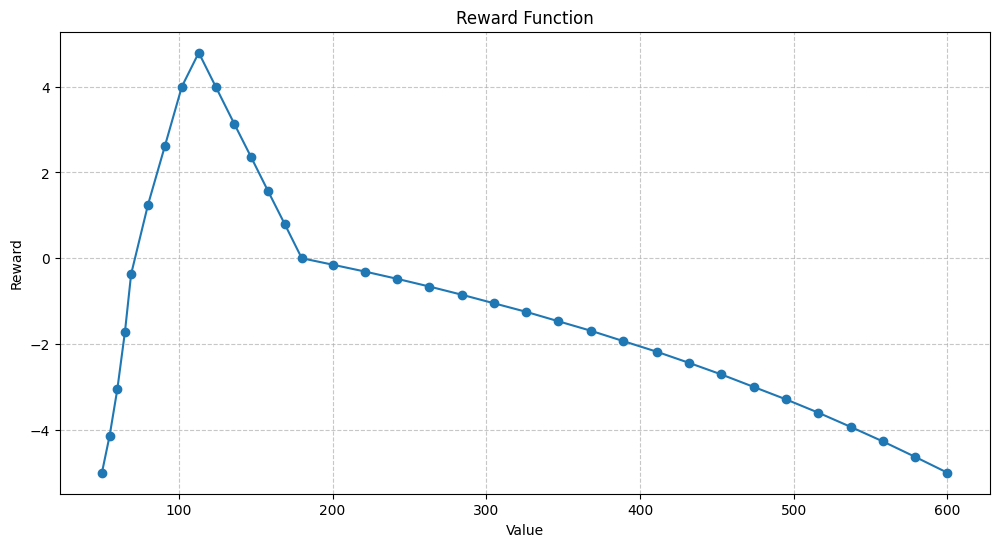

In [7]:


######## TRANSITION FACTORS ########
# A transition factor represents how a variable changes over time,
# given all the things that influence it (its parents). Since the
# next state of a variable is a function of its current state and its
# parents' states, the variable has itself as its first parent.


# # TODO: consider conditioning on latent patient age as well
# TENSOR_GLUCOSE_UTILIZATION = create_normalized_random_tensor(
#     shape=(
#         len(STATE_VALUES_GLUCOSE_UTILIZATION),
#         len(STATE_VALUES_GLUCOSE_UTILIZATION),
#         len(ACTION_VALUES_BASAL_INSULIN),
#     )
# )       
# pump.add_transition_factor(
#     values=TENSOR_GLUCOSE_UTILIZATION,
#     target="glucose_utilization",
#     parents=[
#         "glucose_utilization",
#         "basal_insulin",
#     ],
# )

# TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS = create_high_temperature_identity_tensor(
#     shape=(
#         len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#         len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#         len(STATE_VALUES_PATIENT_AGE),
#     ),
#     std=2,
#     left_skew = .35,
# )
# NOISE_TENSOR = create_normalized_random_tensor(
#     shape=(
#         len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#         len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#         len(STATE_VALUES_PATIENT_AGE),
#     ),
# )
# print(TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS.shape)
# print(NOISE_TENSOR.shape)

# TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS = add_and_normalize_tensors([
#     TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS,
#     NOISE_TENSOR,
# ])


TENSOR_LATENT_IOB = create_generalized_modulated_tensor(
    shape=(
        len(STATE_VALUES_IOB),
        len(STATE_VALUES_IOB),
        len(ACTION_VALUES_BASAL_INSULIN),
    ),
    base_std=3,
)
# pump.add_transition_factor(
#     values=TENSOR_LATENT_IOB,
#     target="latent_iob",
#     parents=[
#         "latent_iob",
#         "basal_insulin",
#     ],
# )
pump.B["latent_iob"].data = jnp.asarray(TENSOR_LATENT_IOB)


TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS = create_generalized_modulated_tensor(
    shape=(
        len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
        len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
        len(STATE_VALUES_PATIENT_AGE),
        # len(STATE_VALUES_MEAL),
        # len(STATE_VALUES_IOB),
        len(STATE_VALUES_MOMENTUM),
        # len(ACTION_VALUES_BASAL_INSULIN),
        len(ACTION_VALUES_CONSTANT),
    ),
    modulator_dims=[3],
    base_std=2,
    noise_level=0.5,
    # std_mod_effects=[2],
    # max_mode_shift_effects=[1],
)

# pump.add_transition_factor(
#     values=TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS,
#     target="uncontrolled_glucose_dynamics",
#     parents=[
#         "uncontrolled_glucose_dynamics",
#         "latent_patient_age",
#         # "meal",
#         # "latent_iob",
#         "momentum",
#         # "basal_insulin",
#         "constant",
#     ],
# )
pump.B["uncontrolled_glucose_dynamics"].data = jnp.asarray(TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS)

TENSOR_MEAL = create_normalized_random_tensor(
    shape=(
        len(STATE_VALUES_MEAL),
        len(STATE_VALUES_MEAL),
        len(ACTION_VALUES_CONSTANT),
    ),
)
# pump.add_transition_factor(
#     values=TENSOR_MEAL,
#     target="meal",
#     parents=[
#         "meal",
#         "constant",
#     ],
# )
pump.B["meal"].data = jnp.asarray(TENSOR_MEAL)


# Patient age is a constant across an episode,
# so we can represent it as an identity matrix.
# We then add a third dimension for the action variable.
TENSOR_PATIENT_AGE = create_normalized_identity_transition_tensor(
    shape=(
        len(STATE_VALUES_PATIENT_AGE),
        len(STATE_VALUES_PATIENT_AGE),
        len(ACTION_VALUES_CONSTANT),
    )
)
# pump.add_transition_factor(
#     values=TENSOR_PATIENT_AGE,
#     target="latent_patient_age",
#     parents=[
#         "latent_patient_age",
#         "constant",
#     ],
# )
pump.B["latent_patient_age"].data = jnp.asarray(TENSOR_PATIENT_AGE)

TENSOR_MOMENTUM = create_generalized_modulated_tensor(
    shape=(
        len(STATE_VALUES_MOMENTUM),
        len(STATE_VALUES_MOMENTUM),
        len(STATE_VALUES_MEAL),
        len(STATE_VALUES_IOB),
        # len(ACTION_VALUES_CONSTANT),
        len(ACTION_VALUES_BASAL_INSULIN),
    ),
    modulator_dims=[2, 3, 4],
    base_std=1,
    std_mod_effects=[0.5, -.5, -1],
    max_mode_shift_effects=[0.5, -0.1, -0.3],

)
# pump.add_transition_factor(
#     values=TENSOR_MOMENTUM,
#     target="momentum",
#     parents=[
#         "momentum",
#         "meal",
#         "latent_iob",
#         # "constant",
#         "basal_insulin",
#     ],
# )
pump.B["momentum"].data = jnp.asarray(TENSOR_MOMENTUM)

######## LIKELIHOOD FACTORS ########
# A likelihood factor represents how likely an observation is,
# given the hidden states that influence it. This allows the POMDP
# to reason backwards to infer the most likely hidden states.
TENSOR_IOB = create_high_temperature_identity_tensor(
    shape=(
        len(OBSERVATION_VALUES_IOB),
        len(STATE_VALUES_IOB),
    )
)

# pump.add_likelihood_factor(
#     values=TENSOR_IOB,
#     target="iob",
#     parents=[
#         "latent_iob",
#     ],
# )
pump.A["iob"].data = jnp.asarray(TENSOR_IOB)

# TENSOR_TOP_POLICY_COUNT_RECENT_STEPS = np.array(
#     [
#         [0, 0, 0, .3, .5],
#         [0, 0, .1, .8, .5],
#         [0, .1, .8, 0, 0],
#         [.5, .8, .1, 0, 0],
#         [.5, .1, 0, 0, 0],
#     ]
# )
# TENSOR_TOP_POLICY_COUNT_RECENT_STEPS = np.divide(TENSOR_TOP_POLICY_COUNT_RECENT_STEPS, np.sum(TENSOR_TOP_POLICY_COUNT_RECENT_STEPS, axis=0, keepdims=True))
# pump.add_likelihood_factor(
#     values=TENSOR_TOP_POLICY_COUNT_RECENT_STEPS,
#     target="top_policy_count_recent_steps",
#     parents=[
#         "momentum",
#     ],
# )


TENSOR_CGM = create_high_temperature_identity_tensor(
    shape=(
        len(OBSERVATION_VALUES_CGM),
        # len(STATE_VALUES_GLUCOSE_UTILIZATION),
        len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
        # len(STATE_VALUES_MEAL),
        # len(STATE_VALUES_PATIENT_AGE),
    )
)
# TENSOR_CGM = np.eye(len(OBSERVATION_VALUES_CGM))
# TENSOR_CGM = create_normalized_random_tensor(
#     shape=(
#         len(OBSERVATION_VALUES_CGM),
#         len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#         len(STATE_VALUES_MEAL),
#         len(STATE_VALUES_PATIENT_AGE),
#     )
# )

# pump.add_likelihood_factor(
#     values=TENSOR_CGM,
#     target="CGM",
#     parents=[
#         "uncontrolled_glucose_dynamics",
#         # "meal",
#     ],
# )
pump.A["CGM"].data = jnp.asarray(TENSOR_CGM)

# past CGM from a previous timestep
# TENSOR_CGM_T_MINUS_1 = create_normalized_random_tensor(
#     shape=(
#         len(OBSERVATION_VALUES_CGM_T_MINUS_1),
#         # len(STATE_VALUES_GLUCOSE_UTILIZATION),
#         # len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#         len(STATE_VALUES_MEAL),
#         # len(STATE_VALUES_PATIENT_AGE),
#     )
# )

# guesswork
TENSOR_CGM_T_MINUS_1 = jnp.array(
    [
        [.3, 0],
        [.3, 0],
        [.3, .1],
        [.1, .2],
        [0, .7],
    ]
)
# pump.add_likelihood_factor(
#     values=TENSOR_CGM_T_MINUS_1,
#     target="CGM_T-1",
#     parents=[
#         # "uncontrolled_glucose_dynamics",
#         "meal",
#     ],
# )
pump.A["CGM_T-1"].data = TENSOR_CGM_T_MINUS_1

# guesswork
TENSOR_CGM_T_MINUS_2 = jnp.array(
    [
        [.3, 0],
        [.3, 0],
        [.4, .02],
        [0, .08],
        [0, .9],
    ]
)
# pump.add_likelihood_factor(
#     values=TENSOR_CGM_T_MINUS_2,
#     target="CGM_T-2",
#     parents=[
#         # "uncontrolled_glucose_dynamics",
#         "meal",
#     ],
# )
pump.A["CGM_T-2"].data = jnp.asarray(TENSOR_CGM_T_MINUS_2)

# # print(f"OBSERVATION_VALUES_BASAL_INSULIN_T_MINUS_1: {len(OBSERVATION_VALUES_BASAL_INSULIN_T_MINUS_1)}")
# # print(f"STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS: {len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS)}")
# TENSOR_BASAL_INSULIN_T_MINUS_1 = create_normalized_random_tensor(
#     shape=(
#         len(OBSERVATION_VALUES_BASAL_INSULIN_T_MINUS_1),
#         len(STATE_VALUES_UNCONTROLLED_GLUCOSE_DYNAMICS),
#     )
# )

# pump.add_likelihood_factor(
#     values=TENSOR_BASAL_INSULIN_T_MINUS_1,
#     target="basal_insulin_T-1",
#     parents=[
#         "uncontrolled_glucose_dynamics",
#     ],
# )

# a likelihood factor for the patient's age, which is an indicator 
# of the endogenous insulin production.
TENSOR_PATIENT_AGE = jnp.eye(len(OBSERVATION_VALUES_PATIENT_AGE))
# pump.add_likelihood_factor(
#     values=TENSOR_PATIENT_AGE,
#     target="patient_age",
#     parents=[
#         "latent_patient_age",
#     ],
# )
pump.A["patient_age"].data = jnp.asarray(TENSOR_PATIENT_AGE)

# TENSOR_HOUR = create_normalized_random_tensor(
#     shape=(
#         len(OBSERVATION_VALUES_HOUR),
#         len(STATE_VALUES_MEAL),
#     ),
# )

# from the simulator
TENSOR_HOUR = jnp.array(
    [
        [1/8, 0.0976],
        [1/8, 0.1550],
        [1/8, 0.0818],
        [1/8, 0.1823],
        [1/8, 0.2100],
        [1/8, 0.0981],
        [1/8, 0.0707],
        [1/8, 0.1046],
    ]
)
TENSOR_HOUR = TENSOR_HOUR / jnp.sum(TENSOR_HOUR, axis=0, keepdims=True)
# pump.add_likelihood_factor(
#     values=TENSOR_HOUR,
#     target="hour",
#     parents=[
#         "meal",
#     ],
# )
# pump.A["hour"].data = TENSOR_HOUR





######## PREFERENCE FACTORS ########
# The agent prefers to keep CGM within a certain range.
# We use a gaussian distribution to reward the model for 
# being in the center of the range.
preferences = dist_gaussian(
    N=len(OBSERVATION_VALUES_CGM),
    scaled_mode=0.31,
    right_skew=.1,
    std=1.6,
)
# Subtracting a small value creates a penalty for being outside the range.
TENSOR_CGM_PREFERENCES = jnp.array([x -.01 for x in preferences])


# Values at the extremes of the range should be penalized more heavily.
# This produces a reward gradient for the model to follow back
# to where it should be.
max_idx = jnp.argmax(TENSOR_CGM_PREFERENCES)

TENSOR_CGM_PREFERENCES = np.zeros(len(OBSERVATION_VALUES_CGM))
DEAD_PENALTY = -5
GOLDILOCKS_REWARD = 5
PEAK_REWARD_VALUE = 110

def exponential_penalty(x, x_start, x_end, y_start, y_end):

    if np.isclose(x_start, x_end):
        return np.full(np.shape(x), y_start, dtype=np.float64)

    dx = x_end - x_start
    dy = y_end - y_start
    if np.isclose(dy, 0.0):
        return np.full(np.shape(x), y_start, dtype=np.float64)
    if np.isclose(abs(dy), 2.0):
        result = y_start + (x - x_start) * (dy / dx)
        if isinstance(result, np.ndarray):
            return result.astype(np.float64)
        return np.float64(result)
    val_for_log = abs(dy) / 2.0
    b = np.log(val_for_log) / dx
    denominator_a = val_for_log - 1.0
    a = dy / denominator_a
    c = y_start - a
    return a * np.exp(b*(x-x_start)) + c

for i, glucose in enumerate(OBSERVATION_VALUES_CGM):
    glucose = float(glucose)
    if glucose == 50:
        TENSOR_CGM_PREFERENCES[i] = DEAD_PENALTY
    elif glucose <= 70:
        # Exponential interpolation between Dead penalty at 50 and 0 at 70
        TENSOR_CGM_PREFERENCES[i] = exponential_penalty(glucose, 50, 70, DEAD_PENALTY, 0)
    elif glucose < PEAK_REWARD_VALUE:
        # Linear interpolation between 0 at 70 and GOLDILOCKS_REWARD at PEAK_REWARD_VALUE
        TENSOR_CGM_PREFERENCES[i] = (glucose - 70) * (GOLDILOCKS_REWARD/(PEAK_REWARD_VALUE-70))
    elif glucose == PEAK_REWARD_VALUE:
        TENSOR_CGM_PREFERENCES[i] = GOLDILOCKS_REWARD
    elif glucose <= 180:
        # Linear interpolation between GOLDILOCKS_REWARD at PEAK_REWARD_VALUE and 0 at 180
        TENSOR_CGM_PREFERENCES[i] = GOLDILOCKS_REWARD - (glucose - PEAK_REWARD_VALUE) * (GOLDILOCKS_REWARD/(180-PEAK_REWARD_VALUE))
    elif glucose < 600:
        # Exponential interpolation between 0 at 180 and DEAD_PENALTY at 600
        TENSOR_CGM_PREFERENCES[i] = exponential_penalty(glucose, 180, 600, 0, DEAD_PENALTY)
    elif glucose == 600:
        TENSOR_CGM_PREFERENCES[i] = DEAD_PENALTY
    else:
        TENSOR_CGM_PREFERENCES[i] = DEAD_PENALTY

# print("Preference values for CGM:")
# print(list(zip(OBSERVATION_VALUES_CGM, [round(x, 2) for x in TENSOR_CGM_PREFERENCES])))
plot_reward_function(list(zip(OBSERVATION_VALUES_CGM, [round(x, 2) for x in TENSOR_CGM_PREFERENCES])))

# pump.add_preference_factor(
#     values=np.array(TENSOR_CGM_PREFERENCES),
#     target="CGM",
# )
pump.C["CGM"].data = jnp.array(TENSOR_CGM_PREFERENCES)


# # don't use too much insulin
# TENSOR_IOB_PREFERENCES = [0 for _ in range(len(OBSERVATION_VALUES_IOB))]
# TENSOR_IOB_PREFERENCES[-1] = -1
# pump.add_preference_factor(
#     values=np.array(TENSOR_IOB_PREFERENCES),
#     target="iob",
# )

# COOPER: Not sure how to format a prior in the new PyMDP
# ######## PRIORS ########
# pump.add_prior_factor(
#     # values=np.array([.6, .1, .05, .1, .15]),
#     values=np.array([.3, .05, .65]), # haven't eaten, meal absorption high, meal absorption low
#     target="meal",
# )

######## VALIDATION ########
# pump.validate()

# ######## PLOT TENSOR SLICE ########
# plot_tensor_slice(TENSOR_UNCONTROLLED_GLUCOSE_DYNAMICS, 4, 3)

In [8]:
# total_size = 0
# for factor in pump.vfg.factors:
#     print(f"\n{factor.variables}")
#     print(factor.values.shape)
#     print(factor.values.size)
#     total_size += factor.values.size

# for variable, data in pump.vfg.variables.items():
#     print(f"\n{variable}")
#     print(data.elements)
#     print(len(data.elements))
# print(f"\ntotal_size: {total_size}")

## Load the agent to Genius

Here we connect to our running instance of Genius and upload our model. If you have a cloud instance, you'll need to change the hostname and port.

In [9]:

import jax.tree_util as jtu
# agent_http_protocol, agent_hostname, agent_port = "http", "localhost", 3000

# agent = GeniusAgent(
#     agent_http_protocol=agent_http_protocol,
#     agent_hostname=agent_hostname,
#     agent_port=agent_port,
# )
# agent.load_genius_model(model=pump)


from pymdp.agent import Agent


B_action_dependencies = [
    [list(model_description["controls"].keys()).index(i) for i in s["controlled_by"]] 
    for s in model_description["states"].values()
]
num_controls = [len(c["elements"]) for c in model_description["controls"].values()]

A = [pump.A[i].data for i in model_description["observations"].keys()]
B = [pump.B[i].data for i in model_description["states"].keys()]

# pA = jtu.tree_map(lambda a: jnp.ones_like(a), A)
# pB = jtu.tree_map(lambda b: jnp.ones_like(b), B)
pA = [jnp.array(a, dtype=jnp.float32) for a in A]
pB = [jnp.array(b, dtype=jnp.float32) for b in B]

POLICY_LEN = 3

agent = Agent(
    A=pump.A,
    # B=jnp.broadcast_to(jnp.asarray(pump.B), (1,) + pump.B.shape),
    # B=jnp.broadcast_to(pump.B, (1,) + pump.B.shape),
    # B=jnp.asarray(pump.B),
    B=pump.B,
    C=pump.C,
    D=pump.D,
    pA=pA,
    pB=pB,
    batch_size=1,
    B_action_dependencies=B_action_dependencies,
    num_controls=num_controls,
    policy_len=POLICY_LEN,
    # learn_A=True,
    learn_B=True,
)

## Inference with Continual Learning

It's time to put our model to the test. We'll run through an episode with each patient, and see how well our model improves over time.

Everything needed to actually run the agent is inside the "ACTION LOOP" section. The rest of the code is just for plotting and tracking statistics. We'll use two metrics of success:
- Survival: How many episodes can the agent get through without `risk` reaching 100?
- Time in Range (TIR): What percentage of the time does the agent spend in the CGM range of 100-180 mg/dL?

Both of these metrics should improve over time as the agent learns. 



In [10]:
print(dir(agent))
print(agent.num_obs)

['A', 'A_dependencies', 'B', 'B_action_dependencies', 'B_dependencies', 'C', 'D', 'E', 'H', 'I', '__abstractclassvars__', '__abstractmethods__', '__abstractvars__', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__replace__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_construct_dependencies', '_construct_flattend_policies', '_flatten_B_action_dims', '_get_default_params', '_get_num_states_from_B', '_validate', 'action_maps', 'action_selection', 'alpha', 'batch_size', 'control_fac_idx', 'decode_multi_actions', 'encode_multi_actions', 'gamma', 'inductive_depth', 'indu

In [ ]:
import pandas as pd
import jax.tree_util as jtu
from jax import random as jr
from pymdp.envs.rollout import infer_and_plan
from jax import jit, vmap


# SOJOURN_TIME = 5

MAX_EPISODE_LENGTH = 500 # about 8 hours
# MAX_EPISODE_LENGTH = 500 * SOJOURN_TIME # about 8 hours

PAST_OBSERVATION_LAG_MULTIPLE = 1

# learning hyperparameters
LEARNING_STOP_BUFFER_EPISODES = 40
LEARN_INTERVAL_EPISODES = 10
LEARN_INTERVAL_STEPS = 500 * SOJOURN_TIME

# Toggles
LEARN_LIKELIHOODS = False
LEARN_TRANSITIONS = True
USING_ALTERNATION = False
LEARNING_STOPPED = False
LEARNING_STOPPED_EPISODE = None
SAVE_ANIMATION = False

# Track cumulative metrics across episodes
cumulative_optimality = []
cumulative_survival = []

TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")
try:
    os.mkdir(f"out/{TIMESTAMP}") # output folder for plots from this run
    os.mkdir(f"out/{TIMESTAMP}/vfg-episodes")
    os.mkdir(f"out/{TIMESTAMP}/control_results")
except Exception as e:
    pass

# pump.save(f"out/{TIMESTAMP}/vfg-0.json") # save the initial VFG

total_steps_across_episodes = 0
total_episodes_completed = 0
total_survival_steps = 0
total_optimal_steps = 0

random_gyms = [(gym_name, gym) for gym_name, gym in gyms.items()] * 5 * SOJOURN_TIME
random.shuffle(random_gyms)
print(f"Total # patients: {len(random_gyms)}")
for gym_name, gym in random_gyms:

    # Alternate likelihoods and transitions every so often
    if USING_ALTERNATION and ((total_episodes_completed+1) % LEARN_INTERVAL_EPISODES == 0):
        print(f"Episode {total_episodes_completed+1}")
        if LEARN_LIKELIHOODS == True:
            LEARN_LIKELIHOODS = False
        else:
            LEARN_LIKELIHOODS = True
        
        if LEARN_TRANSITIONS == True:
            LEARN_TRANSITIONS = False
        else:
            LEARN_TRANSITIONS = True

    

    obs, state_info = gym.reset()
    action_history = [0] * SOJOURN_TIME #starting with lowest basal insulin value
    print(f"discretizing obs: {discretize_observation({"CGM": obs["CGM"]}, {"CGM": OBSERVATION_VALUES_CGM})["CGM"],}")
    obs = {
        # "CGM": discretize_observation({"CGM": obs["CGM"]}, {"CGM": OBSERVATION_VALUES_CGM})["CGM"],
        "CGM": obs["CGM"],
        "patient_age": obs["patient_age"],
        "CGM_T-1": str(len(OBSERVATION_VALUES_CGM_T_MINUS_1)//2), #starting with the same CGM value
        "CGM_T-2": str(len(OBSERVATION_VALUES_CGM_T_MINUS_2)//2),
        "iob": "0",
        # "hour": "60",
        # "top_policy_count_recent_steps": "0",
    } 
    print(f"initial obs: {obs}")
    obs = discretize_observation(obs, {
        "CGM": OBSERVATION_VALUES_CGM,
        "patient_age": OBSERVATION_VALUES_PATIENT_AGE,
        "CGM_T-1": OBSERVATION_VALUES_CGM_T_MINUS_1,
        "CGM_T-2": OBSERVATION_VALUES_CGM_T_MINUS_2,
        "iob": OBSERVATION_VALUES_IOB,
    })
    print(f"discretized obs: {obs}")
    
    cgm_history = [obs["CGM"]]
    # experiment: get slope as CGM_T-1
    slope = len(OBSERVATION_VALUES_CGM_T_MINUS_1) // 2
    obs["CGM_T-1"] = str(slope)

    step = 0

    # plt.ioff() # Turn off interactive mode - No longer needed for saving animation
    fig, ax = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
    fig.suptitle(f"Patient: {gym_name} (Training Episode {total_episodes_completed + 1})")

    # Setup subplots
    ax[0].set_ylabel("Value")
    ax[0].set_title("Risk and CGM (Discretized) over Time")
    ax[0].grid(True)
    line_risk, = ax[0].plot([], [], label='Risk of Hypo- or Hyperglycemia (%)')
    line_cgm_raw, = ax[0].plot([], [], label='CGM (mg glucose / dL blood)')
    line_cgm, = ax[0].plot([], [], label='CGM (Discretized)')
    line_iob, = ax[0].plot([], [], label='Insulin on Board x 2 (Discretized)', color='purple')
    # Placeholder for meal lines legend item
    meal_legend_line, = ax[0].plot([], [], color='r', linestyle='--', label='Meal (unobserved)', lw=0.8)
    ax[0].legend(loc='upper left')
    # Store the artist for meal vlines using a mutable container
    plot_state = {'meal_artist': None}

    ax[1].set_ylabel("Basal Insulin (units/min)")
    ax[1].set_title("Action (Basal Insulin) over Time")
    ax[1].grid(True)
    line_action, = ax[1].plot([], [], marker='.')
    # Set fixed y-axis for insulin action
    max_insulin_value = max(float(x) for x in RAW_ACTION_VALUES_BASAL_INSULIN) if RAW_ACTION_VALUES_BASAL_INSULIN else 1 # Handle empty list case
    ax[1].set_ylim(-0.05 * max_insulin_value, max_insulin_value * 1.05) # Add 5% padding

    ax[2].set_ylabel("TIR Score (%)")
    ax[2].set_title("% Time without Hypo- or Hyperglycemia and Current TIR")
    ax[2].set_ylim(0, 105)
    ax[2].grid(True)
    line_optimality, = ax[2].plot([], [], label='Current TIR (%)', color='g')
    score_text = ax[2].text(0.02, 0.95, "", transform=ax[2].transAxes, verticalalignment='top')
    ax[2].set_xlabel("Step (minutes)")
    # Add legend to the third subplot
    ax[2].legend(loc='lower left')


    # Data storage for plotting
    steps_list = []
    cgm_values_discrete = []
    cgm_values_raw = []
    risk_values = []
    action_values = []
    meal_steps = []
    meal_amounts = []
    optimal_steps_count_episode = 0
    optimality_perc_list = []
    iob_values = []

    top_policy_usage_list = []
    

    # Display initial plot structure - Removed for animation saving
    # display_handle = display.display(fig, display_id=True)
    # plt.ion() # Turn interactive mode back on - Removed for animation saving


    # start with None action, and expand agent.D to add time dimension
    # action = -jnp.ones((agent.batch_size, len(agent.num_controls)), dtype=jnp.int32)
    
    action_idx = 0
    action_prev = None
    action = None

    qs = jtu.tree_map(lambda x: jnp.expand_dims(x, -2), agent.D)

    # reset environment and get initial observation
    rng_key = jr.PRNGKey(0)
    keys = jr.split(rng_key, agent.batch_size + 1)
    rng_key = keys[0]

    
    # get the prior
    qs = jtu.tree_map(lambda x: jnp.expand_dims(x, 1), agent.D) # qs needs a time dimension too



    learn_history = []
    while state_info["risk"] < 100 and step < MAX_EPISODE_LENGTH:

        # --------------------------- ACTION LOOP ---------------------------
        # print(f"obs: {obs}")
        # if obs.keys() != pump.vfg.variables.keys():
        #     # print the keys that are in obs but not in pump.vfg.variables
        #     print(f"keys in obs but not in pump.vfg.variables: {set(obs.keys()) - set(pump.vfg.variables.keys())}")
        #     print(f"keys in pump.vfg.variables but not in obs: {set(pump.vfg.variables.keys()) - set(obs.keys())}")
        if step % SOJOURN_TIME == 0:
            
            # agent.infer_states(obs, qs_init)
            # qs = jtu.tree_map(lambda x: jnp.expand_dims(x, axis=0), agent.D)
            # q_pi, G = agent.infer_policies(qs)
            # action = agent.sample_action(q_pi)
            # control_result = agent.decode_multi_actions(action)



            obs = one_hot_encode_observation(obs, [len(OBSERVATION_VALUES_CGM), len(OBSERVATION_VALUES_PATIENT_AGE), len(OBSERVATION_VALUES_CGM_T_MINUS_1), len(OBSERVATION_VALUES_CGM_T_MINUS_2), len(OBSERVATION_VALUES_IOB)])
            obs = jtu.tree_map(lambda x: x[None, ...], obs)
            # print(f"obs shapes: {[x.shape for x in obs]}")
            # print(f"one hot encoded obs: {obs}")
        

            action_prev = action
            action = agent.encode_multi_actions(jnp.array([[action_idx,0]]))
            qs_prev = qs
            # print(f"type of agent: {type(agent)}")
            # print(f"type of qs: {type(qs)}")
            # print(f"type of obs: {type(obs)}")
            # print(f"type of action: {type(action)}")
            # print(f"type of rng_key: {type(rng_key)}")
            agent, action, qs, info = jit(infer_and_plan)(agent, qs, obs, action, rng_key)
            keys = jr.split(rng_key, agent.batch_size + 1)
            rng_key = keys[0]

            # print(f"qs differs from qs_prev: {any([not jnp.allclose(x, y, atol=1e-4) for x, y in zip(qs, qs_prev)])}")

            # # for learning A and/or B
            # if action_prev is not None and action is not None:
            #     if LEARN_LIKELIHOODS or LEARN_TRANSITIONS:
            #         if LEARN_TRANSITIONS:
            #             # stacking beliefs for B learning
            #             beliefs_B = jtu.tree_map(
            #                 lambda x, y: jnp.concatenate([x, y], axis=1), qs_prev, qs
            #             )
            #             # reshaping action to match the stacked beliefs
            #             action_B = jnp.expand_dims(action_prev, 1)  # adding time dimension
            #         else:
            #             beliefs_B = None
            #             action_B = action_prev

            #         prev_agent = agent

            #         agent = agent.infer_parameters(
            #             qs,
            #             obs,
            #             action_B if agent.learn_B else action_prev,
            #             beliefs_B=beliefs_B,
            #         )

            #         print(f"agent B differs from prev_agent: {any([not jnp.allclose(x, y, atol=1e-4) for x, y in zip(agent.B, prev_agent.B)])}")
            
            # print(f"action: {action}")
            # print(f"info: {info}")
            # print(f"action maps: {agent.action_maps}")
            control_result = agent.decode_multi_actions(action)
            action_idx = control_result[0][0]
            # control_result = agent.encode_multi_actions(control_result)

            # # save the agent.model to a file
            # agent.model.save(f"out/{TIMESTAMP}/vfg-episodes/vfg-b-{total_episodes_completed}.json")

            # # # save the control result to JSON file
            # with open(f"out/{TIMESTAMP}/control_results/control_result_{total_episodes_completed + 1}_{gym_name}.json", "w") as f:
            #     json.dump(control_result, f)

            # track how often the top policy is used
            # if control_result["action_data"]["basal_insulin"]["selected_action"] == len(ACTION_VALUES_BASAL_INSULIN) - 1:
            if action_idx == len(agent.num_controls) - 1:
                top_policy_usage_list.append(1)
            else:
                top_policy_usage_list.append(0)
        else:
            top_policy_usage_list.append(0)
        # print(f"variables with chosen actions: {control_result['action_data'].keys()}")
        if step > 0:
            cgm_history.append(response["state"]["CGM"]) #append previous CGM
        if SOJOURN_TIME > 1:
            # loop through the policy "arpeggio" selected
            i = step % SOJOURN_TIME
            i2 = i % len(BASAL_INSULIN_ARPEGGIOS_3[0])
            policy = control_result["action_data"]["basal_insulin"]["selected_action"]
            action = str(BASAL_INSULIN_ARPEGGIOS_3[policy][i2])
        else:
            # action = control_map(
            #     controls=ACTION_VALUES_BASAL_INSULIN,
            #     chosen_action=control_result["action_data"]["basal_insulin"]["selected_action"],
            # )
            action = ACTION_VALUES_BASAL_INSULIN[action_idx]
        response = get_response_from_glucose_gym(action, gym)
        learn_history.append(obs)
        
        # Capture original CGM before discretization for optimality check
        original_cgm = response['state']['CGM']

        # Now discretize the state
        response["state"] = discretize_observation(response["state"], {"CGM": OBSERVATION_VALUES_CGM})
        # print(f"using CGM_T-1 with lag multiple: {PAST_OBSERVATION_LAG_MULTIPLE}")
        current_iob = calculate_and_bin_iob(
            past_dosages_per_minute=[float(RAW_ACTION_VALUES_BASAL_INSULIN[x]) for x in action_history],
            num_bins=len(OBSERVATION_VALUES_IOB),
            max_expected_iob=5.5, # magic number
            # max_possible_dose=float(RAW_ACTION_VALUES_BASAL_INSULIN[-1]),
            aggregation_window_minutes=IOB_AGGREGATION_WINDOW_MINUTES,
            effect_half_life_minutes=75,
        )
        # count the number of times the top policy has been selected in the past 5 steps
        top_policy_raw_count_recent_steps = sum(top_policy_usage_list[-OBSERVATION_VALUES_TOP_POLICY_COUNT_RECENT_STEPS_LEVELS * SOJOURN_TIME:])
        if top_policy_raw_count_recent_steps > 0:
            top_policy_count_recent_steps = str(min(top_policy_raw_count_recent_steps, OBSERVATION_VALUES_TOP_POLICY_COUNT_RECENT_STEPS_LEVELS-1))
        else:
            top_policy_count_recent_steps = "0"

        act_1 = action_history[-PAST_OBSERVATION_LAG_MULTIPLE * SOJOURN_TIME]
        age = response["state"]["patient_age"]
        obs = {
            "CGM": response["state"]["CGM"],
            "patient_age": 0 if age == "adolescent" else 1,
            "CGM_T-1": str(get_slope_n_back(cgm_history[:i], 20, len(OBSERVATION_VALUES_CGM_T_MINUS_1), (-1, 2))),
            "CGM_T-2": str(get_slope_n_back(cgm_history[:i], 20, len(OBSERVATION_VALUES_CGM_T_MINUS_2), (-5, 5), calculate_acceleration=True)),
            "iob": str(current_iob),
            # "basal_insulin_T-1": OBSERVATION_VALUES_BASAL_INSULIN_T_MINUS_1[act_1],
            # "hour": discretize_observation({"hour": step}, {"hour": OBSERVATION_VALUES_HOUR})["hour"],
            # "top_policy_count_recent_steps": top_policy_count_recent_steps
        }

        # learn parameters

        
            

        if SOJOURN_TIME > 1:
            action_history.append(RAW_ACTION_VALUES_BASAL_INSULIN.index(float(action)))
        else:
            # action_history.append(control_result["action_data"]["basal_insulin"]["selected_action"]) # append the action afterwards
            action_history.append(control_result[0][0]) # append the action afterwards
        # obs = {"CGM": response["state"]["CGM"], "patient_age": response["state"]["patient_age"]}
        # print(f"{step}\tgym: {gym_name}\taction: {float(action):0.3f}\tmeal: {response['state']['meal']:0.3f}\tCGM_orig: {original_cgm:.1f}\tCGM_disc: {response['state']['CGM']}\trisk: {response['state']['risk']:.3f}")

        # --------------------------- / ACTION LOOP ---------------------------

        steps_list.append(step)
        current_cgm_discrete = response['state']['CGM']
        cgm_values_discrete.append(float(current_cgm_discrete))
        cgm_values_raw.append(float(original_cgm))
        risk_values.append(response['state']['risk'])
        action_values.append(float(action))
        meal_amounts.append(response['state']['meal'])
        if response['state']['meal'] > 0:
            meal_steps.append(step)
        iob_values.append(current_iob)

        # Check for optimal range using the original CGM value
        if 70 <= original_cgm <= 180:
             optimal_steps_count_episode += 1
        current_optimality_perc = (optimal_steps_count_episode / (step + 1)) * 100 if step >= 0 else 0
        optimality_perc_list.append(current_optimality_perc)

        state_info = response["state"]
        step += 1

    final_step_count = step # Total frames for the animation

    try:
        # Create DataFrame to store all values
        plot_data = pd.DataFrame({
            'Step': steps_list,
            'Episode': [total_episodes_completed + 1] * len(steps_list),
            'CGM_Discrete': [int(x) for x in cgm_values_discrete],
            'CGM_Raw': [float(x) for x in cgm_values_raw],
            'Risk': risk_values,
            'Action': action_values,
            'meal_amounts': meal_amounts,
            'TIR': optimality_perc_list,
            'IOB': iob_values,
            'learn_likelihoods': [LEARN_LIKELIHOODS] * len(steps_list),
            'learn_transitions': [LEARN_TRANSITIONS] * len(steps_list),
        })
        plot_data.to_csv(f"out/{TIMESTAMP}/episode_{total_episodes_completed + 1}_{gym_name}.csv", index=False)
    except Exception as e:
        print(f"Error saving episode data: {e}")



    # --- Animation Setup ---
    # Make sure meal legend item is added only if meals occurred
    if not meal_steps:
        meal_legend_line.set_visible(False) # Hide the placeholder if no meals
        ax[0].legend(loc='upper left') # Redraw legend without meal line if needed

    def animate(frame):
        
        # Update line data up to current frame
        current_steps = steps_list[:frame+1]
        line_risk.set_data(current_steps, risk_values[:frame+1])
        line_cgm_raw.set_data(current_steps, cgm_values_raw[:frame+1])
        line_cgm.set_data(current_steps, cgm_values_discrete[:frame+1])
        line_iob.set_data(current_steps, [x*2 for x in iob_values[:frame+1]])
        line_action.set_data(current_steps, action_values[:frame+1])
        line_optimality.set_data(current_steps, optimality_perc_list[:frame+1])

        if plot_state['meal_artist']:
            plot_state['meal_artist'].remove()
            plot_state['meal_artist'] = None # Reset

        current_meal_steps = [s for s in meal_steps if s <= frame]
        if current_meal_steps:
            ymin, ymax = ax[0].get_ylim() # Get current y-limits for vlines
            # Ensure ymin/ymax are valid before drawing
            if ymax > ymin:
                 # Assign to the dictionary key
                 plot_state['meal_artist'] = ax[0].vlines(current_meal_steps, ymin=ymin, ymax=ymax, color='r', linestyle='--', lw=0.8)

        # Update score text to show current episode's TIR at this frame
        current_tir = optimality_perc_list[frame] if frame < len(optimality_perc_list) else 0
        score_str = f"Current TIR: {current_tir:.1f}%"
        score_text.set_text(score_str)

        # Rescale axes based on data up to current frame
        ax[0].relim()
        ax[0].autoscale_view() # Autoscale both axes for CGM/Risk
        ax[1].relim()
        ax[1].autoscale_view(scalex=True, scaley=False) # Autoscale x, keep y fixed for Action
        ax[2].relim()
        ax[2].autoscale_view(scalex=True, scaley=False) # Autoscale x, keep y fixed for TIR plot

        # Return tuple of artists that were modified
        # Return tuple of artists that were modified
        artists = [line_risk, line_cgm_raw, line_cgm, line_iob, line_action, line_optimality, score_text]
        # Use the dictionary to check if the artist exists
        if plot_state['meal_artist']:
            artists.append(plot_state['meal_artist'])
        return tuple(artists)

    # --- Create and Save Animation ---
    if final_step_count > 0: # Only create animation if episode ran for at least one step
        print(f"Creating animation for Episode {total_episodes_completed + 1} ({final_step_count} frames)...")
        # Set interval (milliseconds per frame) - e.g., 50ms for 20fps
        anim = FuncAnimation(fig, animate, frames=final_step_count, interval=50, blit=False)

        # Save the animation
        animation_filename = f"out/{TIMESTAMP}/episode_{total_episodes_completed + 1}_{gym_name}.gif"
        try:
            # if SAVE_ANIMATION:
            anim.save(animation_filename, writer='pillow')
            print(f"Saved animation to {animation_filename}")
        except Exception as e:
            print(f"Error saving animation: {e}")
            print("Ensure 'pillow' is installed (`pip install pillow`).")

    # --- Save Static Plot (as before) ---
    # Update title for final static plot
    fig.suptitle(f"Gym: {gym_name} (Episode {total_episodes_completed + 1}) \n Ended at step {final_step_count}/{MAX_EPISODE_LENGTH} -- Learn Likelihoods: {LEARN_LIKELIHOODS}, Learn Transitions: {LEARN_TRANSITIONS}, Policy Length: {POLICY_LEN}")
    # Update score text for final static plot to show overall averages again
    avg_optimality_perc = (total_optimal_steps / total_steps_across_episodes * 100) if total_steps_across_episodes > 0 else 0.0
    avg_survival_perc = (total_survival_steps / total_episodes_completed / MAX_EPISODE_LENGTH * 100) if total_episodes_completed > 0 else 0.0
    score_str_final = (
        f"Avg % of 8hr Session Survival (Prev Episodes): {avg_survival_perc:.1f}%\n"
        f"Avg % Time in Range / TIR (Prev Episodes): {avg_optimality_perc:.1f}%"
    )
    score_text.set_text(score_str_final)
    ax[2].legend(loc='lower left') # Ensure legend is correct

    # Redraw final state for static plot (including final meal lines if any)
    if meal_steps:
        ymin, ymax = ax[0].get_ylim()
        if ymax > ymin:
            ax[0].vlines(meal_steps, ymin=ymin, ymax=ymax, color='r', linestyle='--', lw=0.8) # Draw all meal lines

    plot_filename = f"out/{TIMESTAMP}/episode_{total_episodes_completed + 1}_{gym_name}.png"
    fig.savefig(plot_filename)
    print(f"Saved final plot to {plot_filename}")
    plt.close(fig) # Close the figure after saving plot and animation

    # --- Update Overall Stats and Cumulative Metrics ---
    total_steps_across_episodes += final_step_count
    total_episodes_completed += 1
    total_survival_steps += final_step_count
    total_optimal_steps += optimal_steps_count_episode

    # Calculate and store cumulative metrics
    current_optimality = total_optimal_steps / total_steps_across_episodes * 100
    current_survival = (total_survival_steps / (total_episodes_completed * MAX_EPISODE_LENGTH)) * 100
    cumulative_optimality.append(current_optimality)
    cumulative_survival.append(current_survival)



    # Calculate current episode metrics
    current_episode_optimality = (optimal_steps_count_episode / final_step_count * 100) if final_step_count > 0 else 0
    current_episode_survival = (final_step_count / MAX_EPISODE_LENGTH * 100)

    # Plot cumulative metrics and current episode performance
    fig_metrics, ax_metrics = plt.subplots(figsize=(10, 6))
    episodes = range(1, total_episodes_completed + 1)
    
    # Plot cumulative lines
    for x, y in zip(episodes, cumulative_optimality):
        ax_metrics.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    ax_metrics.plot(episodes, cumulative_optimality, label='Cumulative TIR %', marker='o')
    
    for x, y in zip(episodes, cumulative_survival):
        ax_metrics.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,-15), ha='center')
    ax_metrics.plot(episodes, cumulative_survival, label='Cumulative Survival %', marker='s')


    
    # Check if learning should stop based on performance plateau
    if total_episodes_completed > LEARNING_STOP_BUFFER_EPISODES and not LEARNING_STOPPED:
        # Get metrics for buffer window
        recent_survival = cumulative_survival[-LEARNING_STOP_BUFFER_EPISODES:]
        recent_optimality = cumulative_optimality[-LEARNING_STOP_BUFFER_EPISODES:]
        
        # Check if max values haven't increased
        if max(recent_survival) <= max(cumulative_survival[:-LEARNING_STOP_BUFFER_EPISODES]) and \
           max(recent_optimality) <= max(cumulative_optimality[:-LEARNING_STOP_BUFFER_EPISODES]):
            USING_ALTERNATION = False
            LEARN_LIKELIHOODS = False 
            LEARN_TRANSITIONS = False
            LEARNING_STOPPED_EPISODE = total_episodes_completed
            # agent.model.save(f"out/{TIMESTAMP}/vfg-episodes/vfg-b-{total_episodes_completed}.json")
            print(f"Learning stopped at episode {total_episodes_completed} due to performance plateau")

    # Plot current episode performance
    ax_metrics.annotate(f'{current_episode_optimality:.1f}%', 
                       (total_episodes_completed, current_episode_optimality),
                       textcoords="offset points", xytext=(10,0), ha='left')
    ax_metrics.plot(total_episodes_completed, current_episode_optimality, 'g*', 
                   label='Current Episode TIR %', markersize=10)
    
    ax_metrics.annotate(f'{current_episode_survival:.1f}%',
                       (total_episodes_completed, current_episode_survival),
                       textcoords="offset points", xytext=(10,0), ha='left')
    ax_metrics.plot(total_episodes_completed, current_episode_survival, 'r*',
                   label='Current Episode Survival %', markersize=10)
    
    ax_metrics.set_xlabel('Episode')
    ax_metrics.set_ylabel('Percentage')
    ax_metrics.set_title('Cumulative Performance Metrics')
    ax_metrics.grid(True)
    ax_metrics.legend()
    metrics_filename = f"out/{TIMESTAMP}/cumulative_metrics_episode_{total_episodes_completed}.png"
    fig_metrics.savefig(metrics_filename)
    plt.close(fig_metrics)


    # save the VFG learned from this episode
    # if ((total_episodes_completed+1) % LEARN_INTERVAL_EPISODES == 0) and not LEARNING_STOPPED:
    #     agent.model.save(f"out/{TIMESTAMP}/vfg-episodes/vfg-b-{total_episodes_completed}.json")

    # # save the final VFG
    # agent.get_model_from_server()
    # agent.model.save(f"out/{TIMESTAMP}/vfg-1.json")

    # import pandas as pd
    # # Save detailed metrics for each timestep/episode
    # metrics_df = pd.DataFrame({
    #     'episode': episode_numbers,
    #     'timestep': timesteps,
    #     'cgm_value': cgm_values,
    #     'insulin_action': insulin_actions,
    #     'reward': rewards,
    #     'is_optimal': optimal_steps,
    #     'survival_length': episode_lengths,
    #     'episode_optimality': episode_optimality_scores,
    #     'episode_survival': episode_survival_scores
    # })

    if LEARNING_STOPPED_EPISODE is not None:
        if total_episodes_completed - LEARNING_STOPPED_EPISODE > 30:
            print(f"Done with validation set")
            break

# Save to CSV
metrics_filename = f"out/{TIMESTAMP}/detailed_metrics.csv"
# metrics_df.to_csv(metrics_filename, index=False)

print("\n--- Simulation Summary ---")
print(f"Total Episodes Completed: {total_episodes_completed}")
print(f"Total Steps Across All Episodes: {total_steps_across_episodes}")
if total_episodes_completed > 0:
    avg_steps = total_survival_steps / total_episodes_completed
    avg_survival_score = avg_steps / MAX_EPISODE_LENGTH * 100
    print(f"Average Steps Survived per Episode: {avg_steps:.2f}")
    print(f"Overall Average Survival Score: {avg_survival_score:.2f}%")
if total_steps_across_episodes > 0:
    overall_optimality_score = total_optimal_steps / total_steps_across_episodes * 100
    print(f"Overall Average TIR Score (CGM 70-180): {overall_optimality_score:.2f}%")
else:
    print("No steps were taken across episodes.")
if total_episodes_completed == 0:
     print("No episodes were completed.")


Total # patients: 90
discretizing obs: (11,)
initial obs: {'CGM': 138.56303662832457, 'patient_age': 'adolescent', 'CGM_T-1': '2', 'CGM_T-2': '2', 'iob': '0'}
discretized obs: {'CGM': 11, 'patient_age': 0, 'CGM_T-1': 2, 'CGM_T-2': 2, 'iob': 0}
obs: [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]]), array([[1., 0.]]), array([[0., 0., 1., 0., 0.]]), array([[0., 0., 1., 0., 0.]]), array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
obs: [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]]), array([[1., 0.]]), array([[0., 0., 1., 0., 0.]]), array([[0., 0., 1., 0., 0.]]), array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
obs: [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 